# Field Study Project (Part 3 : Building Mix Dataset)
## Athens University of Economics and Business
## Msc in Business Analytics
## Written by : Xheni Cobanaj (f2822117)
## Supervisor : Mr Damianos Chatziantoniou
## Topic : Customer Segmentation of Food Delivery App

In [1]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 6.2 MB/s eta 0:00:00


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# importing all necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
from datetime import datetime
import re
import itertools
from itertools import product
import string

# For getting optimal number of clusters in hierarchical clustering
from scipy.cluster.hierarchy import dendrogram,linkage
# To scale the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# metrics to evaluate the clusters
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Clustering alorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import plotly as py
import plotly.graph_objs as go
from unidecode import unidecode
from datetime import datetime
# activating DND to disregard the warnings by goiing silent mode
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read Data

In [5]:
df = pd.read_csv("/content/drive/MyDrive/preprocessed_data.csv",header=0,parse_dates= ['order_timestamp','last_order_at','first_order_at'])
#in order to apply the cleaning function and remove characters we convert the column to string

print("Columns present in the data: ",[i for i in df.columns])
print("Number of data points: ",df.shape[0])
df.head()

Columns present in the data:  ['customer_id', 'order_id', 'order_timestamp', 'item_name', 'category_name', 'item_price', 'item_quantity', 'shop_id', 'shop_is_chain', 'delivered_by_efood', 'shop_cuisine', 'is_online_payment', 'order_has_discount_coupon', 'order_from_pinata', 'geographical_region_of_user', 'shop_city', 'geographical_region_of_shop', 'food_score', 'delivery_score', 'service_score', 'last_order_at', 'first_order_at']
Number of data points:  1448011


,customer_id,order_id,order_timestamp,item_name,category_name,item_price,item_quantity,shop_id,shop_is_chain,delivered_by_efood,...,order_has_discount_coupon,order_from_pinata,geographical_region_of_user,shop_city,geographical_region_of_shop,food_score,delivery_score,service_score,last_order_at,first_order_at
0,ffa59d28b6c38f291755acc2777e4fec,294c1055f6764a565f52c98b23b6f877,2021-05-23 00:29:35+00:00,ποικιλία κρεάτων 2 ατόμων,Μερίδες της ώρας,17.00,1,b53467be0eb3414b91f31b7d7ba419ff,False,False,...,False,False,Λάρισα,Λάρισα,Λάρισα,NaN,NaN,NaN,2021-05-30,2018-12-01
1,b878ec7fc5e19df3e8511c02212314dd,102884ef509e62864e4cf1e84327d38e,2021-05-06 14:24:08+00:00,κοτόπουλο παϊδάκια σχάρας το κιλό,Με το κιλό,4.95,1,84d9ee44e457ddef7f2c4f25dc8fa865,True,False,...,False,False,Αθήνα,Αθήνα,Μαρούσι-Δυτικά,NaN,NaN,NaN,2021-05-24,2016-02-26
2,b878ec7fc5e19df3e8511c02212314dd,102884ef509e62864e4cf1e84327d38e,2021-05-06 14:24:08+00:00,φιλετίνια κοτόπουλου πανέ ατομική,Φρέσκες σαλάτες ατομικές,3.10,1,84d9ee44e457ddef7f2c4f25dc8fa865,True,False,...,False,False,Αθήνα,Αθήνα,Μαρούσι-Δυτικά,NaN,NaN,NaN,2021-05-24,2016-02-26
3,08665491d12f6cf4477eddc3afc9ea04,dcea001be354306c6fd6591863cb6327,2021-05-11 19:14:39+00:00,γύρος κοτόπουλο σε πίτα,Τυλιχτά,2.50,1,059ba4b62a266b78c6988528f4ef891c,False,False,...,False,False,Αθήνα,Αθήνα,Αθήνα-Κάτω Πατήσια,NaN,NaN,NaN,2021-05-25,2018-10-22
4,08665491d12f6cf4477eddc3afc9ea04,dcea001be354306c6fd6591863cb6327,2021-05-11 19:14:39+00:00,γύρος κοτόπουλο σε πίτα,Τυλιχτά,2.50,1,059ba4b62a266b78c6988528f4ef891c,False,False,...,False,False,Αθήνα,Αθήνα,Αθήνα-Κάτω Πατήσια,NaN,NaN,NaN,2021-05-25,2018-10-22


In [6]:
#convert type of features to str in order to use the text_cleaning function which is comprised of the re.sub method mostly
df.geographical_region_of_shop=df.geographical_region_of_shop.astype(str)
df.geographical_region_of_user=df.geographical_region_of_user.astype(str)
df.shop_city=df.shop_city.astype(str)

In [ ]:
# #replace "nan" with empty string, because it does not appear as null otherwise,then assign Nan to empty strings
# df['geographical_region_of_shop'] = df['geographical_region_of_shop'].replace(['nan'], '')
# df.geographical_region_of_shop = df.geographical_region_of_shop.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
# #if a value is missing in the geographical region of user column replace in with the value from shop city column
# df.geographical_region_of_ahop=df.geographical_region_of_shop.fillna(df.shop_city, inplace=True)

In [7]:
df[df.geographical_region_of_shop=='nan']

,customer_id,order_id,order_timestamp,item_name,category_name,item_price,item_quantity,shop_id,shop_is_chain,delivered_by_efood,...,order_has_discount_coupon,order_from_pinata,geographical_region_of_user,shop_city,geographical_region_of_shop,food_score,delivery_score,service_score,last_order_at,first_order_at


In [ ]:
# def text_cleaning(text):
  
#   # # make all characters lowercase
#   # text = text.lower()

#   # removing character 
#   text = text.replace("-"," ") 

#   # removing Punctation
#   text = re.sub('[%s]*' % string.punctuation, '',text)

#   # removing numbers
#   text = re.sub('[0-9]+','', text)
#   #text=re.sub("[^A-Za-z]","",text)
 
#   # removing big spaces
#   text = re.sub('  +', ' ', text) 
#   #return unidecode.unidecode(text.decode('utf-8'))
  
#   return(text) 

In [ ]:
# df['geographical_region_of_shop'] = df['geographical_region_of_shop'].apply(text_cleaning)
# df['geographical_region_of_user'] = df['geographical_region_of_user'].apply(text_cleaning)
# df['shop_city'] = df['shop_city'].apply(text_cleaning)

In [ ]:
# loop through each row of the DataFrame and apply unidecode to the city_name column
# for index, row in df.iterrows():
#     df.at[index, 'shop_city'] = unidecode(row['shop_city'])


# Create new features on customer level

## Convert the T/F columns to 0/1

In [8]:
# Replacing columns with f/t to 0/1 in order to use the clustering models
#df = df.replace({"False": 0, "True": 1})
df["shop_is_chain"] = df["shop_is_chain"].astype(int)
df["order_has_discount_coupon"] = df["order_has_discount_coupon"].astype(int)
df["is_online_payment"] = df["is_online_payment"].astype(int)
df["delivered_by_efood"] = df["delivered_by_efood"].astype(int)
df["order_from_pinata"] = df["order_from_pinata"].astype(int)

## Extract specific info about the order from order_timestamp feature

In [9]:
# Creating new features from the datetime column order_timestamp
df["year"]  = df["order_timestamp"].apply(lambda x: x.year)
df['month'] = df['order_timestamp'].apply(lambda x: x.month_name())
df['dayname'] = df['order_timestamp'].apply(lambda x: x.day_name())
df["hour"]  = df["order_timestamp"].apply(lambda x: x.hour)
df["day"]  = df["order_timestamp"].apply(lambda x: x.dayofweek)

## Total value from order

In [10]:
df["TotalSum"] = df["item_quantity"] * df["item_price"]

In [11]:
# Creating a new feature 'TimeType' based on hours to define whether its Morning,Afternoon or Evening
df['part_of_the_day'] = np.where((df["hour"]>5)&(df["hour"]<18), np.where(df["hour"]<12, 'Morning','Afternoon'),'Night')

In [12]:
df['timestamp'] = pd.to_datetime(df['order_timestamp']).dt.date
df['last_order_at'] = pd.to_datetime(df['last_order_at']).dt.date
df['first_order_at'] = pd.to_datetime(df['first_order_at']).dt.date

In [ ]:
# Convert to show date only
# df['timestamp']=pd.to_datetime(df['order_timestamp']).apply(lambda x: x.date())
# df['last_order_at']=pd.to_datetime(df['last_order_at']).apply(lambda x: x.date())
# df['first_order_at']=pd.to_datetime(df['first_order_at']).apply(lambda x: x.date())
# df

## Snapshot day (this is the day were all calculations will be made from)

In [13]:
# Create date variable that records recency
import datetime
snapshot_date = max(df.timestamp) + datetime.timedelta(days=1)
snapshot_date

datetime.date(2021, 6, 1)

## Creation of the dataframe about each customer

Frequency of ordering from different shops: 

In [14]:
# group by customer_id and order_id, and calculate the number of unique order_ids and number of unique order_ids paid online
temp_customers = df.groupby('customer_id').agg(
    recency= ('last_order_at', lambda x: (snapshot_date - x.max()).days),
    monetary=('TotalSum', 'sum'),
    num_orders=('order_id', 'nunique'), 
    days_active= ('first_order_at', lambda x: (snapshot_date - x.min()).days),
    num_shops= ('shop_id', 'nunique'),
    num_items=('item_quantity', 'sum'),
    var_order_items=('item_name','nunique'),
    num_cuisines=('shop_cuisine', 'nunique'),
    categories=('category_name',lambda x: list(set(x))),
    city=('shop_city',lambda x: list(set(x))),
    region=('geographical_region_of_user',lambda x: list(set(x))),
    shop_regions=('geographical_region_of_shop',lambda x: list(set(x))),
    cuisines=('shop_cuisine',lambda x: list(set(x)))
).reset_index()

In [15]:
temp_customers

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",[Αθήνα],[Αθήνα],[Νέα Σμύρνη],"[Σουβλάκια, Μαγειρευτά]"
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",[Αθήνα],[Αθήνα],"[Αθήνα-Ιλίσια-Μαβίλη, Παλαιό Φάληρο, Αθήνα-Νέο...","[Σουβλάκια, Κουλούρια, Ζυμαρικά, Κρέπες, Pizza..."
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",[Κιλκίς],[Κιλκίς],[Κιλκίς],"[Pizza, Καφέδες, Κρέπες]"
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",[Σπάρτη],[Σπάρτη],[Σπάρτη],"[Pizza, Καφέδες]"
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",[Αθήνα],[Αθήνα],"[Ηλιούπολη, Αθήνα-Παγκράτι]","[Σουβλάκια, Κρέπες, Cocktails, Pizza, Καφέδες,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",[Αθήνα],[Αθήνα],"[Περιστέρι-Δυτικά, Νέα Ερυθραία-Εκάλη-Δροσιά-Δ...","[Σουβλάκια, Βάφλες, Κρέπες, Ιταλική, Pizza, Κα..."
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",[Αθήνα],[Αθήνα],[Βριλήσσια],"[Καφέδες, Κρέπες, Σουβλάκια, Burgers]"
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",[Αθήνα],[Αθήνα],[Πετρούπολη-Καματερό],"[Σουβλάκια, Ασιατική, Καφέδες, Burgers, Ψητά -..."
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","[Πάτρα, Αθήνα]","[Πάτρα, Αθήνα]","[Πάτρα 2, Αθήνα-Παγκράτι, Καισαριανή]","[Σουβλάκια, Μαγειρευτά, Κρέπες, Pizza, Καφέδες..."


## Average info about a customer's order

### Create attributes about the average value of an order, the average number of items in an order, and the averange number of categories in an order

In [16]:
temp_customers['avg_spent']=temp_customers['monetary'] / temp_customers['num_orders']
temp_customers['avg_items_per_order']=temp_customers['num_items'] / temp_customers['num_orders']
temp_customers['avg_num_categories_per_order']=temp_customers['categories'].apply(len)/ temp_customers['num_orders']


In [17]:
pct_online1 = df.groupby(['customer_id', 'order_id'])['shop_is_chain'].max().groupby('customer_id').mean().reset_index()
pct_online1.columns = ['customer_id', 'perc_chain_shops']
pct_online2 = df.groupby(['customer_id', 'order_id'])['delivered_by_efood'].max().groupby('customer_id').mean().reset_index()
pct_online2.columns = ['customer_id', 'perc_delivered_by_efood']
pct_online3 = df.groupby(['customer_id', 'order_id'])['order_has_discount_coupon'].max().groupby('customer_id').mean().reset_index()
pct_online3.columns = ['customer_id', 'perc_has_discount_coupon']
pct_online4 = df.groupby(['customer_id', 'order_id'])['is_online_payment'].max().groupby('customer_id').mean().reset_index()
pct_online4.columns = ['customer_id', 'perc_paid_online']
pct_online5 = df.groupby(['customer_id', 'order_id'])['order_from_pinata'].max().groupby('customer_id').mean().reset_index()
pct_online5.columns = ['customer_id', 'perc_from_pinata']
# merge the dataframes on customer_id
customers_df = temp_customers.merge(pct_online1, on='customer_id').merge(pct_online2, on='customer_id').merge(pct_online3, on='customer_id').merge(pct_online4, on='customer_id').merge(pct_online5, on='customer_id')
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,...,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",...,[Νέα Σμύρνη],"[Σουβλάκια, Μαγειρευτά]",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",...,"[Αθήνα-Ιλίσια-Μαβίλη, Παλαιό Φάληρο, Αθήνα-Νέο...","[Σουβλάκια, Κουλούρια, Ζυμαρικά, Κρέπες, Pizza...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",...,[Κιλκίς],"[Pizza, Καφέδες, Κρέπες]",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",...,[Σπάρτη],"[Pizza, Καφέδες]",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",...,"[Ηλιούπολη, Αθήνα-Παγκράτι]","[Σουβλάκια, Κρέπες, Cocktails, Pizza, Καφέδες,...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",...,"[Περιστέρι-Δυτικά, Νέα Ερυθραία-Εκάλη-Δροσιά-Δ...","[Σουβλάκια, Βάφλες, Κρέπες, Ιταλική, Pizza, Κα...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",...,[Βριλήσσια],"[Καφέδες, Κρέπες, Σουβλάκια, Burgers]",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",...,[Πετρούπολη-Καματερό],"[Σουβλάκια, Ασιατική, Καφέδες, Burgers, Ψητά -...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...",...,"[Πάτρα 2, Αθήνα-Παγκράτι, Καισαριανή]","[Σουβλάκια, Μαγειρευτά, Κρέπες, Pizza, Καφέδες...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000


In [18]:
customers_df['city'] = customers_df['city'].astype(str)
customers_df['region'] = customers_df['region'].astype(str)
customers_df['cuisines'] = customers_df['cuisines'].astype(str)
customers_df['shop_regions'] = customers_df['shop_regions'].astype(str)

In [19]:
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,...,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",...,['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",...,"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",...,['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",...,['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",...,"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",...,"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",...,['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",...,['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...",...,"['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000


## Frequency of orders

###Which customers order every week ?

In [20]:
df['week'] = df['order_timestamp'].dt.week
orders_per_week = df.groupby(['customer_id', 'week'])['order_id'].count().reset_index()
weeks_per_customer = orders_per_week.groupby('customer_id')['week'].nunique().reset_index()
weeks_per_customer['orders_every_week'] = weeks_per_customer['week'] == weeks_per_customer['week'].max()
customers_df = customers_df.merge(weeks_per_customer, on='customer_id')
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,...,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,week,orders_every_week
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",...,12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,10,True
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",...,8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,9,False
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",...,3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,7,False
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",...,2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,9,False
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",...,9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",...,18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,7,False
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",...,10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,7,False
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",...,16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,8,False
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...",...,6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,8,False


## Part of the day 

### What part of the day do the customers order most from?
Three columns of the percentage of orders placed during morning,afternoon or nighttime.

In [21]:
orders_per_customer = df.groupby(['customer_id', 'part_of_the_day'])['order_id'].nunique().reset_index()
total_orders_per_customer = df.groupby('customer_id')['order_id'].nunique().reset_index()
total_orders_per_customer = total_orders_per_customer.rename(columns={'order_id': 'total_orders'})

orders_per_customer = pd.merge(orders_per_customer, total_orders_per_customer, on='customer_id')

orders_per_customer['morning_percentage'] = orders_per_customer.apply(lambda x: x['order_id'] / x['total_orders'] if x['part_of_the_day'] == 'Morning' else 0, axis=1)
orders_per_customer['afternoon_percentage'] = orders_per_customer.apply(lambda x: x['order_id'] / x['total_orders'] if x['part_of_the_day'] == 'Afternoon' else 0, axis=1)
orders_per_customer['night_percentage'] = orders_per_customer.apply(lambda x: x['order_id'] / x['total_orders'] if x['part_of_the_day'] == 'Night' else 0, axis=1)

time_period = orders_per_customer.groupby('customer_id').agg(
    morning_perc=('morning_percentage', 'sum'),
    afternoon_perc=('afternoon_percentage', 'sum'),
    night_perc= ('night_percentage', 'sum')).reset_index()
customers_df = pd.merge(customers_df, time_period, on='customer_id')
customers_df


,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,...,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,week,orders_every_week,morning_perc,afternoon_perc,night_perc
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",...,0.294118,0.000000,0.0,0.000000,0.323529,10,True,0.000000,0.058824,0.941176
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",...,0.475000,0.150000,0.0,0.625000,0.000000,9,False,0.250000,0.450000,0.300000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",...,0.000000,0.000000,0.0,0.923077,0.000000,7,False,0.384615,0.153846,0.461538
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",...,0.000000,0.000000,0.0,0.000000,0.000000,9,False,0.836735,0.163265,0.000000
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",...,0.595745,0.000000,0.0,0.574468,0.000000,9,False,0.021277,0.212766,0.765957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",...,0.583333,0.166667,0.0,0.583333,0.500000,7,False,0.166667,0.250000,0.583333
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",...,0.875000,0.062500,0.0,0.250000,0.000000,7,False,0.000000,0.500000,0.500000
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",...,0.466667,0.000000,0.0,0.866667,0.000000,8,False,0.000000,0.000000,1.000000
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...",...,0.700000,0.000000,0.0,0.400000,0.000000,8,False,0.100000,0.350000,0.550000


In [22]:
pd.set_option('display.max_columns', None)
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,week,orders_every_week,morning_perc,afternoon_perc,night_perc
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,10,True,0.000000,0.058824,0.941176
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,9,False,0.250000,0.450000,0.300000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,7,False,0.384615,0.153846,0.461538
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,9,False,0.836735,0.163265,0.000000
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,9,False,0.021277,0.212766,0.765957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,7,False,0.166667,0.250000,0.583333
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,7,False,0.000000,0.500000,0.500000
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,8,False,0.000000,0.000000,1.000000
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,8,False,0.100000,0.350000,0.550000


Interesting finding about coffee!

In [23]:
# Define the word to search for
search_word = 'Καφέδες'

# Define a lambda function to check if the word is in any of the lists in the column
contains_word = lambda row: search_word in row

Customers that order every day (they are only 73 out of almost 25000 so it was decided not to use this column!

In [ ]:
# Convert the order_date column to a datetime object and extract the date component
# df['order_date'] = pd.to_datetime(df['order_timestamp']).dt.date

# # Group the dataframe by customer_id to get the number of unique order dates for each customer
# grouped_df = df.groupby('customer_id')['order_date'].nunique().reset_index(name='num_order_dates')

# # Get the set of all order dates in the dataframe
# all_dates = set(df['order_date'].unique())

# # Filter the grouped_df to include only the customers who have ordered every day
# customers_ordered_every_day = grouped_df['num_order_dates'] == len(all_dates)
# customers_ordered_every_day
# # # Join the customers_ordered_every_day series with the original df to add a boolean column
# # df = df.merge(customers_ordered_every_day, on='customer_id')
# # df['ordered_every_day'] = df['num_order_dates_y'] == len(all_dates)
# # df.drop(['num_order_dates_y'], axis=


## Frequency of orders study

###Which customers order at least 3 days per week ?

In [24]:
# Convert the order_date column to a datetime object and extract the weekday and weekofyear components
df['weekday'] = pd.to_datetime(df['order_timestamp']).dt.weekday
df['weekofyear'] = pd.to_datetime(df['order_timestamp']).dt.weekofyear
# Group the dataframe by customer_id and weekofyear to get the count of orders for each week for each customer
grouped_df = df.groupby(['customer_id', 'weekofyear'])['weekday'].nunique().reset_index(name='num_weekdays')
# Filter the grouped_df to include only the customers who have ordered at least 3 days per week every week
customers_ordered_3_days = grouped_df.groupby('customer_id')['num_weekdays'].apply(lambda x: (x >= 3).all())
# Join the customers_ordered_3_days series with the original df to add a boolean column
customers_df = customers_df.merge(customers_ordered_3_days, on='customer_id')
# Join the customers_ordered_3_days series with the original df to add a boolean column
customers_df['ordered_3_days_every_week'] = customers_df['num_weekdays']

# Join the customers_ordered_3_days series with the original df to add a boolean column
customers_df.drop(['week', 'num_weekdays'], axis=1, inplace=True)
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,False,0.100000,0.350000,0.550000,False


## Food, Delivery and Service Score Attributes

In [25]:
# Create a new column in the orders dataframe indicating whether the customer left a review or not in any of the three score columns
df['left_review'] = df[['food_score', 'delivery_score', 'service_score']].notnull().any(axis=1)

In [26]:
df["left_review"] = df["left_review"].astype(int)

### Label customers based on whether they leave a review or not

In [27]:
reviews=df[df['left_review'] == 1].groupby(['customer_id', 'order_id']).size().groupby('customer_id').size().reset_index(name='scores_count')
# Join the review_count series with the original df to add the review count column

# Merge the two DataFrames using a left join and replace any missing values with 0
customers_df = customers_df.merge(reviews, on='customer_id', how='left').fillna(0)
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False,0.0
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False,0.0
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False,0.0
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False,0.0
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False,0.0
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False,0.0
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False,0.0
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,False,0.100000,0.350000,0.550000,False,0.0


In [28]:
# Create a new DataFrame with customer ID, order count, and review count
#customers_df.rename(columns={'order_id': 'Order Count', 'review_column': 'Review Count'}, inplace=True)

# Define a function to assign labels based on review ratio
def review_labels(row):
    if row['scores_count'] == 0:
        return 'Mystery Maven'
    elif row['num_orders'] == 0:
        return 'No Orders'
    elif row['scores_count'] / row['num_orders'] <= 0.25:
        return 'Silent Shopper'
    elif row['scores_count'] / row['num_orders'] <= 0.5:
        return 'Occasional'
    elif row['scores_count'] / row['num_orders'] <= 0.75:
        return 'Feedback Fanatic'
    else:
        return 'Super User'

# Apply the function to create a new column with ratio labels
customers_df['leaves_reviews'] = customers_df.apply(review_labels, axis=1)

# Merge the ratio labels back to the original DataFrame
#df = pd.merge(df, customers_df[['customer_id', 'Review Ratio']], on='customer_id')

# Print the resulting DataFrame
#print(df)


In [29]:
customers_df.leaves_reviews.value_counts()

Mystery Maven       22786
Silent Shopper       1800
Occasional            228
Super User             95
Feedback Fanatic       89
Name: leaves_reviews, dtype: int64

## Day of the week order placement

###How many orders are placed on weekends and how many on weekdays feature

In [30]:
# Create a new dataframe with binary values for each day of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_dummies = pd.get_dummies(df['dayname'])
day_dummies = day_dummies.reindex(columns=days, fill_value=0)

# Concatenate the new dataframe with the original dataframe
new_df = pd.concat([df[['customer_id','order_id']], day_dummies], axis=1)
#keep unique order ids 
new_df = new_df.drop_duplicates(subset='order_id', keep='first')
# compute total number of orders
new_df['total_orders'] = new_df.iloc[:, 2:].sum(axis=1)  
#sum orders during the week
new_df['weekend_orders_pct'] = new_df[['Saturday', 'Sunday']].sum(axis=1) / new_df['total_orders']
#sum orders during the weekend
new_df['weekday_orders_pct'] = new_df.iloc[:, 2:7].sum(axis=1) / new_df['total_orders']
#group by customer id and order to get the values
result4 = new_df.groupby(['customer_id', 'order_id'])[['weekend_orders_pct', 'weekday_orders_pct']].mean()
result5 = result4.groupby('customer_id')[['weekend_orders_pct', 'weekday_orders_pct']].mean()
customers_df=customers_df.merge(result5[['weekend_orders_pct','weekday_orders_pct']],on='customer_id')

In [31]:
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False,0.0,Mystery Maven,0.264706,0.735294
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False,0.0,Mystery Maven,0.225000,0.775000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False,0.0,Mystery Maven,0.307692,0.692308
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False,0.0,Mystery Maven,0.183673,0.816327
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False,0.0,Mystery Maven,0.319149,0.680851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False,0.0,Mystery Maven,0.583333,0.416667
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False,0.0,Mystery Maven,0.250000,0.750000
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False,0.0,Mystery Maven,0.533333,0.466667
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,False,0.100000,0.350000,0.550000,False,0.0,Mystery Maven,0.350000,0.650000


In [32]:
customers_df.avg_items_per_order.describe()

count    24998.000000
mean         3.062275
std          1.119368
min          1.000000
25%          2.312500
50%          2.863636
75%          3.571429
max         19.421053
Name: avg_items_per_order, dtype: float64

In [33]:
# Explode the column to create a new row for each value in the list
exploded_df = customers_df.explode('region')

# Get the unique values in the column
unique_values = exploded_df['region'].unique()

# Print out the unique values
print(unique_values)

["['Αθήνα']" "['Κιλκίς']" "['Σπάρτη']" ... "['Κως', 'Λάρισα']"
 "['Αλεξανδρούπολη', 'Καρδίτσα']" "['Κρυονέρι', 'Σταμάτα']"]


##Geographical Region of user, keeping the one that most orders were placed from

In [34]:
# Group by customer id and region, and count the number of orders per region
grouped2 = df.groupby(['customer_id', 'geographical_region_of_user'])['order_id'].count().reset_index()

# Sort by customer id and number of orders per region in descending order
sorted_df = grouped2.sort_values(['customer_id', 'order_id'], ascending=[True, False])

# Drop duplicate customer id rows, keeping the first row with the highest number of orders per region
unique_df = sorted_df.drop_duplicates(subset='customer_id', keep='first')

# Reset the index
unique_df = unique_df.reset_index(drop=True)

# Print the resulting dataframe
unique_df.drop(columns='order_id',inplace=True)
# Merge the two DataFrames
customers_df = customers_df.merge(unique_df, on='customer_id')
customers_df


,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False,0.0,Mystery Maven,0.264706,0.735294,Αθήνα
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False,0.0,Mystery Maven,0.225000,0.775000,Αθήνα
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False,0.0,Mystery Maven,0.307692,0.692308,Κιλκίς
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False,0.0,Mystery Maven,0.183673,0.816327,Σπάρτη
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False,0.0,Mystery Maven,0.319149,0.680851,Αθήνα
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False,0.0,Mystery Maven,0.583333,0.416667,Αθήνα
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False,0.0,Mystery Maven,0.250000,0.750000,Αθήνα
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False,0.0,Mystery Maven,0.533333,0.466667,Αθήνα
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,False,0.100000,0.350000,0.550000,False,0.0,Mystery Maven,0.350000,0.650000,Αθήνα


## Coffee orders!

###Percentage of coffee orders for each user feature

In [39]:
# filter for "coffee" cuisine, drop duplicates of order_id, group by customer ID, count the number of coffee orders per customer
coffee_orders = df[df['shop_cuisine'] == 'Καφέδες'].drop_duplicates(subset='order_id').groupby('customer_id').size().reset_index(name='coffee_count')

# group the data by customer ID, count the unique order IDs to get the total number of orders per customer
total_orders = df.groupby('customer_id')['order_id'].nunique().reset_index(name='total_orders')

# merge the two dataframes on customer ID, use left join to keep all customers from total_orders
merged_coffee = pd.merge(total_orders, coffee_orders, on='customer_id', how='left')

# fill NaN values with 0 for customers who did not order coffee
merged_coffee['coffee_count'] = merged_coffee['coffee_count'].fillna(0)

# calculate the percentage of orders that were coffee for each customer
merged_coffee['coffee_percentage'] = merged_coffee['coffee_count'] / merged_coffee['total_orders']

merged_coffee


,customer_id,total_orders,coffee_count,coffee_percentage
0,0001496e540173a40362759ed10b3ce2,34,0.0,0.000000
1,0003b7de618c1acfc67eac91b853b287,40,17.0,0.425000
2,00045e9d1c96d7e2353f886704e51c88,13,9.0,0.692308
3,000e223791e890e85938d71bee32cf5a,49,1.0,0.020408
4,0016652ea3c3a1176dd2385e89de9ff6,47,9.0,0.191489
...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,12,3.0,0.250000
24994,fff262fbc647360700cee69566e26989,16,5.0,0.312500
24995,fff355794e97eaaf07f53f4fdb4d0cd2,15,2.0,0.133333
24996,fffacf61b056a50e5cf7173b94c939df,20,10.0,0.500000


In [42]:
customers_df = customers_df.merge(merged_coffee[['customer_id', 'coffee_percentage']], on='customer_id')
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False,0.0,Mystery Maven,0.264706,0.735294,Αθήνα,0.000000
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False,0.0,Mystery Maven,0.225000,0.775000,Αθήνα,0.425000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False,0.0,Mystery Maven,0.307692,0.692308,Κιλκίς,0.692308
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False,0.0,Mystery Maven,0.183673,0.816327,Σπάρτη,0.020408
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False,0.0,Mystery Maven,0.319149,0.680851,Αθήνα,0.191489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False,0.0,Mystery Maven,0.583333,0.416667,Αθήνα,0.250000
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False,0.0,Mystery Maven,0.250000,0.750000,Αθήνα,0.312500
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False,0.0,Mystery Maven,0.533333,0.466667,Αθήνα,0.133333
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,False,0.100000,0.350000,0.550000,False,0.0,Mystery Maven,0.350000,0.650000,Αθήνα,0.500000


###Best customer Ever!

In [43]:
customers_df.set_index('customer_id')
# find the customer ID with the max value in most columns
max_cols = (customers_df == customers_df.max()).sum(axis=1)
max_customer = max_cols.idxmax()
max_customer

1551

In [44]:
customers_df[customers_df.customer_id=='c7786aa61f55a9b73edebb79126c281c']

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage
19397,c7786aa61f55a9b73edebb79126c281c,2,3517.7,106,1693,60,784,294,21,"[Handmade treats, Σπιτικά αναψυκτικά, Νηστίσιμ...","['Παιανία', 'Αθήνα']",['Αθήνα'],"['Γέρακας-Γλυκά Νερά-Ανθούσα', 'Μελίσσια-Πεντέ...","['Παγωτό', 'Καφέδες', 'Sushi', 'Burgers', 'Αρτ...",33.185849,7.396226,1.075472,0.566038,0.273585,0.0,0.367925,0.009434,True,0.09434,0.509434,0.396226,False,0.0,Mystery Maven,0.377358,0.622642,Αθήνα,0.169811


## Quantity of different categories in an order

## Percentage of orders with more than two items for each user feature

In [45]:
df[df.item_quantity>=2]

,customer_id,order_id,order_timestamp,item_name,category_name,item_price,item_quantity,shop_id,shop_is_chain,delivered_by_efood,shop_cuisine,is_online_payment,order_has_discount_coupon,order_from_pinata,geographical_region_of_user,shop_city,geographical_region_of_shop,food_score,delivery_score,service_score,last_order_at,first_order_at,year,month,dayname,hour,day,TotalSum,part_of_the_day,timestamp,week,weekday,weekofyear,left_review
5,08665491d12f6cf4477eddc3afc9ea04,dcea001be354306c6fd6591863cb6327,2021-05-11 19:14:39+00:00,κεμπάπ χειροποίητο σε πίτα,Τυλιχτά,2.5,2,059ba4b62a266b78c6988528f4ef891c,0,0,Σουβλάκια,1,0,0,Αθήνα,Αθήνα,Αθήνα-Κάτω Πατήσια,NaN,NaN,NaN,2021-05-25,2018-10-22,2021,May,Tuesday,19,1,5.0,Night,2021-05-11,19,1,19,0
12,ae13c51311a65fe67b4ad7ce278853e0,76cffe53374cbf27f86bf8a716f2beb4,2021-05-05 10:05:10+00:00,freddo espresso,Καφέδες,1.8,2,2f38b3925d4db2a311576540bee25572,1,0,Καφέδες,1,0,0,Πειραιάς,Αθήνα,Πειραιάς-Καμίνια-Κοκκινιά,NaN,NaN,NaN,2021-05-30,2020-03-03,2021,May,Wednesday,10,2,3.6,Morning,2021-05-05,18,2,18,0
13,ae13c51311a65fe67b4ad7ce278853e0,76cffe53374cbf27f86bf8a716f2beb4,2021-05-05 10:05:10+00:00,νερό 500ml,Αναψυκτικά,0.5,4,2f38b3925d4db2a311576540bee25572,1,0,Καφέδες,1,0,0,Πειραιάς,Αθήνα,Πειραιάς-Καμίνια-Κοκκινιά,NaN,NaN,NaN,2021-05-30,2020-03-03,2021,May,Wednesday,10,2,2.0,Morning,2021-05-05,18,2,18,0
17,d6eedc952988d63c866682f4c007e2b7,30eb384b6ebcaa4480e16dd713777ea0,2021-05-19 21:33:57+00:00,classic burger,Burgers,3.5,3,d4177b29bcb2471a8713b689816697a8,1,1,Burgers,0,0,0,Αθήνα,Αθήνα,Ηράκλειο,NaN,NaN,NaN,2021-05-27,2016-01-24,2021,May,Wednesday,21,2,10.5,Night,2021-05-19,20,2,20,0
18,d6eedc952988d63c866682f4c007e2b7,30eb384b6ebcaa4480e16dd713777ea0,2021-05-19 21:33:57+00:00,πατάτες large,Πατάτες & Extras,2.7,2,d4177b29bcb2471a8713b689816697a8,1,1,Burgers,0,0,0,Αθήνα,Αθήνα,Ηράκλειο,NaN,NaN,NaN,2021-05-27,2016-01-24,2021,May,Wednesday,21,2,5.4,Night,2021-05-19,20,2,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447975,8735603bb9c21afcc7bb17bc8c56b96b,034a27b3a6cbb38ac2353f0a734844ba,2021-04-16 10:51:13+00:00,κουλούρι κλασικό τραγανό,Νηστίσιμα,0.5,4,20d0b1fd7526283e64f20330d630afa0,1,0,Κουλούρια,0,0,0,Αθήνα,Αθήνα,Ίλιον,NaN,NaN,NaN,2021-05-23,2020-12-24,2021,April,Friday,10,4,2.0,Morning,2021-04-16,15,4,15,0
1447981,f98332421ff33eed3490922adf061bb6,ca0c52c32b0bda019aea86584be79c81,2021-04-21 09:33:12+00:00,freddo espresso,Καφέδες,1.7,2,b437fbb92af66ac8602316a292b734a3,1,0,Καφέδες,1,0,0,Θεσσαλονίκη,Θεσσαλονίκη,Θεσσαλονίκη-Πυλαία-Πανόραμα,NaN,NaN,NaN,2021-05-29,2016-05-17,2021,April,Wednesday,9,2,3.4,Morning,2021-04-21,16,2,16,0
1447998,18451c7f61608f58d414b8419b143d52,daa8252f23da43f3c5fad668cc5f96a5,2021-04-08 21:13:18+00:00,σουβλάκι κοτόπουλο στήθος σε πίτα,Τυλιχτά,2.4,2,f83e99491ed8d07cff6845504129d5bd,0,0,Σουβλάκια,0,0,0,Πάτρα,Πάτρα,Πάτρα 2,NaN,NaN,NaN,2021-05-27,2016-01-21,2021,April,Thursday,21,3,4.8,Night,2021-04-08,14,3,14,0
1448004,0c0af5099932e93de2f72c4f56c153d4,be04391aa8a1143cb777e91b163b16a9,2021-05-18 21:06:41+00:00,καλαμάκι κοτόπουλο,Τεμάχια,1.3,3,f8737dfde6b0fac9e83b0b64652e2376,0,0,Σουβλάκια,0,0,0,Πάτρα,Πάτρα,Πάτρα 1,5.0,5.0,5.0,2021-05-30,2016-02-06,2021,May,Tuesday,21,1,3.9,Night,2021-05-18,20,1,20,1


In [46]:
# group by customer_id and apply a lambda function to count the number of times
# item_quantity >= 1 for each customer
quantity_more_than_2 =df.groupby('customer_id')['item_quantity'].apply(lambda x: (x >= 2).sum()).reset_index(name='count')

customers_df['percentage_with_more_than_2']=quantity_more_than_2['count']/customers_df['num_orders']
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False,0.0,Mystery Maven,0.264706,0.735294,Αθήνα,0.000000,0.382353
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False,0.0,Mystery Maven,0.225000,0.775000,Αθήνα,0.425000,0.175000
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False,0.0,Mystery Maven,0.307692,0.692308,Κιλκίς,0.692308,0.000000
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False,0.0,Mystery Maven,0.183673,0.816327,Σπάρτη,0.020408,0.000000
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False,0.0,Mystery Maven,0.319149,0.680851,Αθήνα,0.191489,0.234043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False,0.0,Mystery Maven,0.583333,0.416667,Αθήνα,0.250000,0.166667
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False,0.0,Mystery Maven,0.250000,0.750000,Αθήνα,0.312500,0.125000
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False,0.0,Mystery Maven,0.533333,0.466667,Αθήνα,0.133333,0.400000
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6.680000,2.400000,1.150000,0.700000,0.000000,0.0,0.400000,0.000000,False,0.100000,0.350000,0.550000,False,0.0,Mystery M

## GDP per Capital Data

In [47]:
elstat = pd.read_excel(r'/content/drive/MyDrive/GDP_PER_CAPITA.xlsx', sheet_name='Sheet1')
gdp_info = pd.DataFrame(elstat, columns=['Περιφέρειες και νομοί','2020*','Regions'])
gdp_info=gdp_info[~gdp_info['Περιφέρειες και νομοί'].str.isupper()].reset_index(drop=True)

In [48]:
# Round column A to the nearest integer
gdp_info['GDP'] = gdp_info['2020*'].round(0)
gdp_info['prefecture'] = gdp_info['Περιφέρειες και νομοί']
gdp_info.drop(columns=['2020*','Περιφέρειες και νομοί'], inplace=True)

In [49]:
# split comma-separated values in column prefecture and create new rows
# pd.set_option('display.max_rows', 87)

gdp_info = gdp_info.assign(prefecture=gdp_info['prefecture'].str.split(',')).explode('prefecture').reset_index(drop=True)
gdp_info['prefecture'] = gdp_info['prefecture'].str.strip()


In [50]:
gdp_info

,Regions,GDP,prefecture
0,Attiki,21134.0,Αττική
1,Voreios Tomeas Athinon,25665.0,Βόρειος Τομέας Αθηνών
2,Dytikos Tomeas Athinon,10608.0,Δυτικός Τομέας Αθηνών
3,Kentrikos Tomeas Athinon,30454.0,Κεντρικός Τομέας Αθηνών
4,Notios Tomeas Athinon,18127.0,Νότιος Τομέας Αθηνών
...,...,...,...
82,Argolida,14408.0,Αργολίδα
83,Arkadia,17931.0,Αρκαδία
84,Korinthia,13212.0,Κορινθία
85,Lakonia,11864.0,Λακωνία


In [51]:
# Group orders by customer and location and count the number of orders
df3 = df.groupby(['customer_id', 'geographical_region_of_shop']).agg({'order_id': 'count'}).reset_index()

# Sort by count and drop duplicates to keep only the location with the highest count for each customer
max_orders = df3.sort_values('order_id', ascending=False).drop_duplicates('customer_id').reset_index(drop=True)

# Print the resulting dataframe
max_orders

,customer_id,geographical_region_of_shop,order_id
0,a702193e88fbcd649e6eec90d67d5a06,Χαλκίδα,557
1,a3b494cede85bc23a1d0551bf8a11ada,Χολαργός-Παπάγου,435
2,2c524856cc61e2d59dbbd41c453fbe1c,Νίκαια,423
3,2d1d18d506ff73f0dc94d240fab0815f,Αθήνα-Εξάρχεια-Πανεπιστήμιο,382
4,dce41e4eb4a3dd31c0e526da4b1b3474,Βόλος,371
...,...,...,...
24993,62e1b3685498018c6367afce605aa701,Κώς,5
24994,17932beb378abff1ee75a93e70950024,Κερατσίνι,4
24995,2061b4ac8aa46c364e81567b3808df9d,Θεσσαλονίκη-Άνω Πόλη,3
24996,25064a84704ce206447b6a94c03d9da9,Αθήνα-Ομόνοια-Πλ. Βάθης-Στ. Λαρίσης,3


In [52]:
max_orders['geographical_region_of_shop'] = max_orders['geographical_region_of_shop'].str.strip()

In [53]:
max_orders

,customer_id,geographical_region_of_shop,order_id
0,a702193e88fbcd649e6eec90d67d5a06,Χαλκίδα,557
1,a3b494cede85bc23a1d0551bf8a11ada,Χολαργός-Παπάγου,435
2,2c524856cc61e2d59dbbd41c453fbe1c,Νίκαια,423
3,2d1d18d506ff73f0dc94d240fab0815f,Αθήνα-Εξάρχεια-Πανεπιστήμιο,382
4,dce41e4eb4a3dd31c0e526da4b1b3474,Βόλος,371
...,...,...,...
24993,62e1b3685498018c6367afce605aa701,Κώς,5
24994,17932beb378abff1ee75a93e70950024,Κερατσίνι,4
24995,2061b4ac8aa46c364e81567b3808df9d,Θεσσαλονίκη-Άνω Πόλη,3
24996,25064a84704ce206447b6a94c03d9da9,Αθήνα-Ομόνοια-Πλ. Βάθης-Στ. Λαρίσης,3


## Create dictionary with cities

In [54]:
pref_dict = {
    'Δυτικός Τομέας Αθηνών': ['Αγία Βαρβάρα','Αθήνα-Σεπόλια','Αθήνα-Κολωνός','Πετρούπολη-Καματερό','Αιγάλεω-Ανατολικά','Αιγάλεω-Δυτικά','Ίλιον','Περιστέρι-Ανατολικά', 'Περιστέρι-Δυτικά','Άγιοι Ανάργυροι', 'Χαϊδάρι-Σκαραμαγκάς','Περιστέρι','Πετρούπολη','Χαιδάρι-Σκαραμαγκάς','Αγία Βαρβάρα','Σκαραμαγκάς','Χαϊδαρίου'],
    'Κεντρικός Τομέας Αθηνών': ['Αθήνα','Υμηττός','Αθήνα-Ομόνοια-Πλ. Βάθης-Στ. Λαρίσης','Νέα Χαλκηδόνα','Αθήνα-Βικτώρια-Πλ. Αττικής','Αθήνα-Σύνταγμα-Πλάκα','Ταύρος','Αθήνα-Ρούφ-Βοτανικός','Νέα Φιλαδέλφεια','Αθήνα-Πατήσια-Πλατεία Αμερικής','Αθήνα-Κολωνάκι','Αθήνα-Θησείο-Ψυρρή-Μεταξουργείο','Αθήνα-Κουκάκι','Αθήνα-Ιλίσια-Μαβίλη','Δάφνη','Αθήνα-Πετράλωνα','Αθήνα-Εξάρχεια-Πανεπιστήμιο','Καισαριανή','Αθήνα-Νεάπολη-Λυκαβηττός','Αθήνα-Αμπελόκηποι-Μιχαλακοπούλου-Κατεχάκη','Αθήνα-Αμπελόκηποι-Πανόρμου','Αθήνα-Κάτω Πατήσια','Βύρωνας','Αθήνα-Άνω Πατήσια','Ζωγράφου','Αθήνα-Κυψέλη','Αθήνα-Νέος Κόσμος','Αθήνα-Παγκράτι'],
    'Βόρειος Τομέας Αθηνών': ['Νέα Ιωνία','Κηφισιά-Κεφαλάρι-Πολιτεία','Μεταμόρφωση','Λυκόβρυση-Πεύκη','Αθήνα-Γκύζη-Νέα Φιλοθέη','Ηράκλειο','Μαρούσι-Δυτικά','Γαλάτσι','Αγία Παρασκευή','Κηφισιά-Άνω', 'Μελίσσια', 'Νέο Ψυχικό', 'Πεντέλη','Νέα Ερυθραία-Εκάλη-Δροσιά-Διόνυσος','Νέο Ψυχικό-Πεντάγωνο','Μελίσσια-Πεντέλη','Βριλήσσια', 'Χολαργός-Παπάγου','Χαλάνδρι-Πολύδροσο', 'Χαλάνδρι-Κάτω', 'Κηφισιά-Κάτω','Μαρούσι-Ανατολικά','Μεταμόρφωση'],
    'Ανατολική Αττική': ['Ανάβυσσος','Αρτέμιδα','Λαγονήσι','Ψυχικό-Φιλοθέη','Σταμάτα-Κρυονέρι-Άνοιξη-Άγιος Στέφανος','Βάρη-Βουλιαγμένη','Βούλα','Γέρακας-Γλυκά Νερά-Ανθούσα','Αχαρνές','Σπάτα', 'Νέος Βουτζάς', 'Σταμάτα', 'Μαρκόπουλο', 'Καλύβια Θορικού', 'Κρυονέρι','Κερατέα','Ντράφι','Μαραθώνας','Πικέρμι','Πόρτο Ράφτη ','Σαρωνίδα','Ροδόπολη','Ανάβυσσος','Άρτεμις', 'Ραφήνα', 'Μαρκόπουλο', 'Σπάτα', 'Άνοιξη', 'Νέα Μάκρη','Άγιος Στέφανος','Δροσιά','Παλλήνη','Διόνυσος','Μάνδρα','Παιανία','Κορωπί','Θρακομακεδόνες'],
    'Δυτική Αττική': ['Άνω Λιόσια','Μαγούλα', 'Φυλή', 'Μάνδρα', 'Ελευσίνα', 'Μέγαρα','Ασπρόπυργος',' Οινόη','Άγιοι Ανάργυροι'],
    'Νότιος Τομέας Αθηνών': ['Ελληνικό','Μοσχάτο','Αργυρούπολη','Άλιμος','Άνω Γλυφάδα','Γλυφάδα','Παλαιό Φάληρο', 'Ηλιούπολη','Καλλιθέα-Δυτικά', 'Καλλιθέα-Ανατολικά', 'Νέα Σμύρνη','Άγιος Δημήτριος'],
    'Κρήτη' : ['Φαιστός','Ρέθυμνο Κρήτης','Ρέθυμνο Κρήτη','Χανιά Κρήτης', 'Χανιά Κρήτη','Σητεία Κρήτης', 'Σητεία Κρήτη','Άγιος Νικόλαος Κρήτης', 'Άγιος Νικόλαος Κρήτη','Ηράκλειο Κρήτης 1','Ηράκλειο Κρήτης 3','Ηράκλειο Κρήτης 2','Ιεράπετρα Κρήτη','Ιεράπετρα Κρήτης'],
    'Πειραιάς' : ['Νέο Φάληρο',"Άγιος Ιωάννης Ρέντης",'Πειραιάς-Κέντρο','Πειραιάς-Πειραική','Κερατσίνι','Πειραιάς','Νίκαια','Κορυδαλλός','Πειραιάς-Καμίνια-Κοκκινιά','Πειραιάς-Μανιάτικα-Αγία Σοφία-Παπαστράτειο','Πειραιάς-Καστέλλα-Πανεπιστήμιο','Πέραμα','Πειραιάς-Δραπετσώνα','Κερατσίνι','Άγιος Ιωαννης','Ρέντη'],
    'Ρόδος':['Ιαλυσός Κρεμαστή'],
    'Ημαθία':['Αλεξάνδρεια','Αλεξάνδρεια','Βέροια','Νάουσα'],
    'Θεσσαλονίκη': ['Θεσσαλονίκη-Επανομή','Θεσσαλονίκη-Λαγκαδάς','Θεσσαλονίκη-Σίνδος','Θεσσαλονίκη-Εύοσμος-Ελευθέριο-Κορδελιό-Σταυρούπολη', 'Θεσσαλονίκη-Άνω Πόλη', 'Θεσσαλονίκη-Καλαμαριά-Παλιά Παραλία', 'Θεσσαλονίκη-Τούμπα', 'Θεσσαλονίκη-Κέντρο Ανατολικά-Πανεπιστήμιο-40 Εκκλησιές', 'Θεσσαλονίκη-Κέντρο Δυτικά-Δικαστήρια-Παλιός Σταθμός-Αμπελόκηποι-Ξηροκρήνη-Μενεμένη', 'Θεσσαλονίκη-Χαριλάου-Μαρτίου-Βουλγάρη', 'Θεσσαλονίκη-Νεάπολη-Συκιές-Πολίχνη', 'Θεσσαλονίκη-Ανάληψη', 'Θεσσαλονίκη-Αγία Τριάδα-(Μακεδονία Παλλάς)', 'Θεσσαλονίκη-Κέντρο-Αγίου Δημητρίου', 'Θεσσαλονίκη-Αγία Τριάδα-(28ης Οκτωβρίου)', 'Θεσσαλονίκη-Τριανδρία-ΆνωΤούμπα', 'Θεσσαλονίκη-Πυλαία-Πανόραμα', 'Θεσσαλονίκη-Ευκαρπία-Ωραιόκαστρο', 'Θεσσαλονίκη-Περαία-Νέοι Επιβάτες-Αγία Τριάδα-Νέα Μηχανιώνα', 'Θεσσαλονίκη-Θέρμη', 
                    'Θεσσαλονίκη-Πεύκα'],
    'Κοζάνη':['Πτολεμαίδα'],
    'Νήσοι':['Πτολεμαίδα','Πόρος','Αίγινα','Σαλαμίνα','Σπέτσες'],
    'Αργολίδα':['Άργος','Ναύπλιο'],
    'Μαγνησία':['Αλμυρός','Βόλος'],
    'Αχαΐα': ['Αίγιο','Πάτρα','Πάτρα 1','Πάτρα 2','Πάτρα 3'],
    'Λακωνία': ['Σκάλα','Σπάρτη','Σπάρτη ','Γύθειο'],
    'Πέλλα':['Γιαννιτσά','Έδεσσα'],
    'Ευρυτανία':['Καρπενήσι'],
    'Πιερία':['Κατερίνη'],
   'Ηλεία':['Πύργος'],
    'Έβρος':['Ορεστιάδα','Αλεξανδρούπολη','Διδυμότειχο'],
    'Εύβοια':['Χαλκίδα','Κάρυστος'],
    'Κορινθία':['Κιάτο','Κόρινθος','Λουτράκι'],
    'Αιτωλοακαρνανία':['Μεσολόγγι','Ναύπακτος','Αγρίνιο'],
    'Μεσσηνία' :['Καλαμάτα'],
    'Ροδόπη': ['Κομοτηνή'],
    'Αρκαδία':['Τρίπολη'],
    'Φθιώτιδα':['Λαμία'],
    'Βοιωτία': ['Λιβαδειά','Θήβα'],
   'Θεσπρωτία':['Ηγουμενίτσα'],
   'Κως':['Κώς'],
   'Κεφαλληνία' : ['Κεφαλονιά'],
   'Χαλκιδική':['Χαλκιδική 1'],
   'Νότιο Αιγαίο':['Λέρος']}

In [55]:
# Define a function that maps cities to their respective regions
def get_region(city):
    for region, cities in pref_dict.items():
        if city in cities:
            return region
    return city

# Add a new column to the DataFrame that maps cities to regions_dict
max_orders['prefecture'] = max_orders['geographical_region_of_shop'].apply(get_region)

# Print the resulting DataFrame
max_orders

,customer_id,geographical_region_of_shop,order_id,prefecture
0,a702193e88fbcd649e6eec90d67d5a06,Χαλκίδα,557,Εύβοια
1,a3b494cede85bc23a1d0551bf8a11ada,Χολαργός-Παπάγου,435,Βόρειος Τομέας Αθηνών
2,2c524856cc61e2d59dbbd41c453fbe1c,Νίκαια,423,Πειραιάς
3,2d1d18d506ff73f0dc94d240fab0815f,Αθήνα-Εξάρχεια-Πανεπιστήμιο,382,Κεντρικός Τομέας Αθηνών
4,dce41e4eb4a3dd31c0e526da4b1b3474,Βόλος,371,Μαγνησία
...,...,...,...,...
24993,62e1b3685498018c6367afce605aa701,Κώς,5,Κως
24994,17932beb378abff1ee75a93e70950024,Κερατσίνι,4,Πειραιάς
24995,2061b4ac8aa46c364e81567b3808df9d,Θεσσαλονίκη-Άνω Πόλη,3,Θεσσαλονίκη
24996,25064a84704ce206447b6a94c03d9da9,Αθήνα-Ομόνοια-Πλ. Βάθης-Στ. Λαρίσης,3,Κεντρικός Τομέας Αθηνών


In [56]:
gdp_info

,Regions,GDP,prefecture
0,Attiki,21134.0,Αττική
1,Voreios Tomeas Athinon,25665.0,Βόρειος Τομέας Αθηνών
2,Dytikos Tomeas Athinon,10608.0,Δυτικός Τομέας Αθηνών
3,Kentrikos Tomeas Athinon,30454.0,Κεντρικός Τομέας Αθηνών
4,Notios Tomeas Athinon,18127.0,Νότιος Τομέας Αθηνών
...,...,...,...
82,Argolida,14408.0,Αργολίδα
83,Arkadia,17931.0,Αρκαδία
84,Korinthia,13212.0,Κορινθία
85,Lakonia,11864.0,Λακωνία


In [57]:
# Merge the two dataframes on the 'prefecture' column
merged_gdp = pd.merge(max_orders, gdp_info[['prefecture', 'GDP']], on='prefecture', how='left')
merged_gdp

,customer_id,geographical_region_of_shop,order_id,prefecture,GDP
0,a702193e88fbcd649e6eec90d67d5a06,Χαλκίδα,557,Εύβοια,13415.0
1,a3b494cede85bc23a1d0551bf8a11ada,Χολαργός-Παπάγου,435,Βόρειος Τομέας Αθηνών,25665.0
2,2c524856cc61e2d59dbbd41c453fbe1c,Νίκαια,423,Πειραιάς,18143.0
3,2d1d18d506ff73f0dc94d240fab0815f,Αθήνα-Εξάρχεια-Πανεπιστήμιο,382,Κεντρικός Τομέας Αθηνών,30454.0
4,dce41e4eb4a3dd31c0e526da4b1b3474,Βόλος,371,Μαγνησία,11668.0
...,...,...,...,...,...
24993,62e1b3685498018c6367afce605aa701,Κώς,5,Κως,12428.0
24994,17932beb378abff1ee75a93e70950024,Κερατσίνι,4,Πειραιάς,18143.0
24995,2061b4ac8aa46c364e81567b3808df9d,Θεσσαλονίκη-Άνω Πόλη,3,Θεσσαλονίκη,13091.0
24996,25064a84704ce206447b6a94c03d9da9,Αθήνα-Ομόνοια-Πλ. Βάθης-Στ. Λαρίσης,3,Κεντρικός Τομέας Αθηνών,30454.0


In [58]:
pd.set_option('display.max_rows', 204)
merged_gdp.prefecture.value_counts()

Κεντρικός Τομέας Αθηνών    4276
Βόρειος Τομέας Αθηνών      3097
Νότιος Τομέας Αθηνών       3074
Θεσσαλονίκη                2795
Δυτικός Τομέας Αθηνών      2202
Πειραιάς                   1909
Κρήτη                      1254
Ανατολική Αττική            982
Αχαΐα                       830
Λάρισα                      516
Μαγνησία                    477
Ιωάννινα                    353
Ρόδος                       261
Μεσσηνία                    258
Έβρος                       256
Ξάνθη                       228
Καβάλα                      213
Φθιώτιδα                    185
Αιτωλοακαρνανία             177
Εύβοια                      175
Κοζάνη                      170
Δυτική Αττική               122
Τρίκαλα                     108
Πιερία                      102
Ροδόπη                       95
Ημαθία                       86
Δράμα                        81
Σέρρες                       78
Καρδίτσα                     74
Αρκαδία                      71
Λακωνία                      68
Κορινθία

 ## Cencus 2021 Data

In [59]:
pop = pd.read_excel(r'/content/drive/MyDrive/nom_plith_2021.xlsx', sheet_name='ΝΟΜΙΜΟΣ2021')
population_df = pd.DataFrame(pop, columns=['Περιγραφή','Πληθυσμός 2021'])
# Rename the columns using a dictionary
population_df = population_df.rename(columns={'Περιγραφή': 'dimos', 'Πληθυσμός 2021': 'population'})
population_df

,dimos,population
0,ΣΥΝΟΛΟ ΧΩΡΑΣ,9716889
1,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΡΟΔΟΠΗΣ,101767
2,ΔΗΜΟΣ ΚΟΜΟΤΗΝΗΣ,54833
3,ΔΗΜΟΤΙΚΗ ΕΝΟΤΗΤΑ ΚΟΜΟΤΗΝΗΣ,48971
4,ΔΗΜΟΤΙΚΗ ΕΝΟΤΗΤΑ ΑΙΓΕΙΡΟΥ,3258
...,...,...
1441,ΔΗΜΟΣ ΣΦΑΚΙΩΝ,3052
1442,ΔΗΜΟΤΙΚΗ ΕΝΟΤΗΤΑ ΣΦΑΚΙΩΝ,3052
1443,ΑΓΙΟ ΟΡΟΣ,1514
1444,ΑΓΙΟ ΟΡΟΣ (ΑΥΤΟΔΙΟΙΚΗΤΟ),1514


In [60]:
df_subset = population_df.iloc[:1] # keep first two rows
#df_subset = df_subset.append(population_df.iloc[989:1164, :])

In [61]:
# boolean indexing to subset DataFrame
#df_subset = population_df.append(population_df[population_df['dimos'].str.startswith('ΔΗΜΟΣ')]) # keep rows that start with 'ΔΗΜΟΣ'
df_subset = df_subset.append(population_df[population_df['dimos'].str.startswith('ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ')]).reset_index(drop=True) # keep rows that start with 'ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ'
df_subset


,dimos,population
0,ΣΥΝΟΛΟ ΧΩΡΑΣ,9716889
1,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΡΟΔΟΠΗΣ,101767
2,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΔΡΑΜΑΣ,95701
3,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΕΒΡΟΥ,134776
4,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΘΑΣΟΥ,12815
5,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΒΑΛΑΣ,117057
6,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΞΑΝΘΗΣ,107548
7,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΘΕΣΣΑΛΟΝΙΚΗΣ,884945
8,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΗΜΑΘΙΑΣ,136602
9,ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΙΛΚΙΣ,85885


In [62]:
# define dictionary of words to replace
replace_dict = {'ΔΗΜΟΤΙΚΗ ΕΝΟΤΗΤΑ ': '', 'ΔΗΜΟΣ ': '', 'ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ': ''}

# replace words in column using replace() method with regex=True
df_subset['dimos'] = df_subset['dimos'].replace(replace_dict, regex=True)
df_subset

,dimos,population
0,ΣΥΝΟΛΟ ΧΩΡΑΣ,9716889
1,ΡΟΔΟΠΗΣ,101767
2,ΔΡΑΜΑΣ,95701
3,ΕΒΡΟΥ,134776
4,ΘΑΣΟΥ,12815
5,ΚΑΒΑΛΑΣ,117057
6,ΞΑΝΘΗΣ,107548
7,ΘΕΣΣΑΛΟΝΙΚΗΣ,884945
8,ΗΜΑΘΙΑΣ,136602
9,ΚΙΛΚΙΣ,85885


In [63]:
# lowercase the matching columns in both dataframes
merged_gdp['prefecture'] = merged_gdp['prefecture'].str.lower()
df_subset['dimos'] = df_subset['dimos'].str.lower()
merged_gdp['geographical_region_of_shop'] = merged_gdp['geographical_region_of_shop'].str.lower()


In [64]:
# from google.colab import files
# df_subset.to_csv('output.csv', encoding = 'utf-8-sig') 
# files.download('output.csv')

Read the census dataset after a small cleaning process was done in Excel

In [65]:
census = pd.read_csv("/content/drive/MyDrive/output.csv",header=0)
census.drop(columns='Unnamed: 0',inplace=True)

Remove tabs from left and right

In [66]:
census['dimos'] = census['dimos'].str.strip()

Remove accents since the regions are in greek to make our life easier!

In [67]:
import unicodedata

merged_gdp['prefecture'] = merged_gdp['prefecture'].apply(lambda x: ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn'))

merged_gdp


,customer_id,geographical_region_of_shop,order_id,prefecture,GDP
0,a702193e88fbcd649e6eec90d67d5a06,χαλκίδα,557,ευβοια,13415.0
1,a3b494cede85bc23a1d0551bf8a11ada,χολαργός-παπάγου,435,βορειος τομεας αθηνων,25665.0
2,2c524856cc61e2d59dbbd41c453fbe1c,νίκαια,423,πειραιας,18143.0
3,2d1d18d506ff73f0dc94d240fab0815f,αθήνα-εξάρχεια-πανεπιστήμιο,382,κεντρικος τομεας αθηνων,30454.0
4,dce41e4eb4a3dd31c0e526da4b1b3474,βόλος,371,μαγνησια,11668.0
...,...,...,...,...,...
24993,62e1b3685498018c6367afce605aa701,κώς,5,κως,12428.0
24994,17932beb378abff1ee75a93e70950024,κερατσίνι,4,πειραιας,18143.0
24995,2061b4ac8aa46c364e81567b3808df9d,θεσσαλονίκη-άνω πόλη,3,θεσσαλονικη,13091.0
24996,25064a84704ce206447b6a94c03d9da9,αθήνα-ομόνοια-πλ. βάθης-στ. λαρίσης,3,κεντρικος τομεας αθηνων,30454.0


In [68]:
import unicodedata

merged_gdp['geographical_region_of_shop'] = merged_gdp['geographical_region_of_shop'].apply(lambda x: ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn'))

merged_gdp

,customer_id,geographical_region_of_shop,order_id,prefecture,GDP
0,a702193e88fbcd649e6eec90d67d5a06,χαλκιδα,557,ευβοια,13415.0
1,a3b494cede85bc23a1d0551bf8a11ada,χολαργος-παπαγου,435,βορειος τομεας αθηνων,25665.0
2,2c524856cc61e2d59dbbd41c453fbe1c,νικαια,423,πειραιας,18143.0
3,2d1d18d506ff73f0dc94d240fab0815f,αθηνα-εξαρχεια-πανεπιστημιο,382,κεντρικος τομεας αθηνων,30454.0
4,dce41e4eb4a3dd31c0e526da4b1b3474,βολος,371,μαγνησια,11668.0
...,...,...,...,...,...
24993,62e1b3685498018c6367afce605aa701,κως,5,κως,12428.0
24994,17932beb378abff1ee75a93e70950024,κερατσινι,4,πειραιας,18143.0
24995,2061b4ac8aa46c364e81567b3808df9d,θεσσαλονικη-ανω πολη,3,θεσσαλονικη,13091.0
24996,25064a84704ce206447b6a94c03d9da9,αθηνα-ομονοια-πλ. βαθης-στ. λαρισης,3,κεντρικος τομεας αθηνων,30454.0


In [69]:
merged_gdp_pop = pd.merge(merged_gdp, census[['dimos', 'population']],  left_on='prefecture', right_on='dimos',how='outer')

In [70]:
merged_gdp_pop = merged_gdp_pop[merged_gdp_pop['customer_id'].notnull()]
merged_gdp_pop

,customer_id,geographical_region_of_shop,order_id,prefecture,GDP,dimos,population
0,a702193e88fbcd649e6eec90d67d5a06,χαλκιδα,557.0,ευβοια,13415.0,ευβοια,213179.0
1,e58ce6707a77204cc91293890928c542,χαλκιδα,184.0,ευβοια,13415.0,ευβοια,213179.0
2,2a2398b958dca74dfd531f43bd220344,χαλκιδα,165.0,ευβοια,13415.0,ευβοια,213179.0
3,1fcbc95efd34aabcd378d7838acc97f9,χαλκιδα,163.0,ευβοια,13415.0,ευβοια,213179.0
4,9c6671899b515212656894c6af46408f,χαλκιδα,145.0,ευβοια,13415.0,ευβοια,213179.0
...,...,...,...,...,...,...,...
24993,c344fffaf396e47d1cfd4e557920d370,σαμος,28.0,σαμος,9835.0,σαμος,30200.0
24994,679dcfccf433bf422b87ac82e1d88f66,σαμος,27.0,σαμος,9835.0,σαμος,30200.0
24995,01a5d4b270516a2360992eb9259d5ff2,καρπενησι,35.0,ευρυτανια,9417.0,ευρυτανια,24545.0
24996,0a175605e3c3700075a175431845b9a2,ηγουμενιτσα,12.0,θεσπρωτια,11338.0,θεσπρωτια,47947.0


In [71]:
merged_gdp_pop[merged_gdp_pop.population.isnull()]

,customer_id,geographical_region_of_shop,order_id,prefecture,GDP,dimos,population
9934,c69355a42d3f413cb3faca62424bd6d0,ηρακλειο κρητης 1,366.0,κρητη,12374.0,NaN,NaN
9935,88745182e0e56541f955b6deb7a40da6,χανια κρητης,325.0,κρητη,12374.0,NaN,NaN
9936,2ba8082ba3bd5a954d156e77df02cfe3,ηρακλειο κρητης 1,311.0,κρητη,12374.0,NaN,NaN
9937,a3e9616fc241ff5c8b3665575cc11e6a,ηρακλειο κρητης 2,288.0,κρητη,12374.0,NaN,NaN
9938,7d3d0e47e9cac2f339b9a09c71ac6c3c,ηρακλειο κρητης 1,286.0,κρητη,12374.0,NaN,NaN
...,...,...,...,...,...,...,...
11186,69655c5a117de3b70ca86dd6c0c6299c,ηρακλειο κρητης 2,9.0,κρητη,12374.0,NaN,NaN
11187,daaeb8ecd39ff8d3481e6b0113392d25,ηρακλειο κρητης 1,8.0,κρητη,12374.0,NaN,NaN
24980,6c4754042e62ffe148e5306f35513b06,λερος,43.0,νοτιο αιγαιο,14572.0,NaN,NaN
24981,f7e540d2a976023e5bc7363bf2ed7da5,λερος,38.0,νοτιο αιγαιο,14572.0,NaN,NaN


Fill some values that can not match manually :

In [72]:
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'λερος') , 'population'] =7.917
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'ιεραπετρα κρητης') , 'population']=73258
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'σητεια κρητης') , 'population']=73258
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'φαιστος') | (merged_gdp_pop['geographical_region_of_shop'] == 'ηρακλειο κρητης 1'), 'population'] =285528
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'ηρακλειο κρητης 2') | (merged_gdp_pop['geographical_region_of_shop'] == 'ηρακλειο κρητης 3'), 'population'] =285528
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'χανια κρητης') , 'population'] =144259
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'αγιος νικολαος κρητης') , 'population'] =285528
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'ρεθυμνο κρητης') , 'population'] =79801
merged_gdp_pop.loc[(merged_gdp_pop['geographical_region_of_shop'] == 'αγιος νικολαος κρητης'), 'population'] =73258


Check

In [73]:
merged_gdp_pop[merged_gdp_pop.population.isnull()]

,customer_id,geographical_region_of_shop,order_id,prefecture,GDP,dimos,population


In [74]:
customers_df = customers_df.merge(merged_gdp_pop[['customer_id','prefecture','GDP','population']], on='customer_id')
customers_df

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.452941,4.411765,0.705882,0.294118,0.000000,0.0,0.000000,0.323529,True,0.000000,0.058824,0.941176,False,0.0,Mystery Maven,0.264706,0.735294,Αθήνα,0.000000,0.382353,νοτιος τομεας αθηνων,18127.0,425112.0
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.583750,2.475000,1.050000,0.475000,0.150000,0.0,0.625000,0.000000,False,0.250000,0.450000,0.300000,False,0.0,Mystery Maven,0.225000,0.775000,Αθήνα,0.425000,0.175000,νοτιος τομεας αθηνων,18127.0,425112.0
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.369231,1.000000,0.230769,0.000000,0.000000,0.0,0.923077,0.000000,False,0.384615,0.153846,0.461538,False,0.0,Mystery Maven,0.307692,0.692308,Κιλκίς,0.692308,0.000000,κιλκις,10609.0,85885.0
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.500000,1.102041,0.081633,0.000000,0.000000,0.0,0.000000,0.000000,False,0.836735,0.163265,0.000000,False,0.0,Mystery Maven,0.183673,0.816327,Σπάρτη,0.020408,0.000000,λακωνια,11864.0,87104.0
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.717021,2.872340,0.787234,0.595745,0.000000,0.0,0.574468,0.000000,False,0.021277,0.212766,0.765957,False,0.0,Mystery Maven,0.319149,0.680851,Αθήνα,0.191489,0.234043,νοτιος τομεας αθηνων,18127.0,425112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.620833,3.833333,2.500000,0.583333,0.166667,0.0,0.583333,0.500000,False,0.166667,0.250000,0.583333,False,0.0,Mystery Maven,0.583333,0.416667,Αθήνα,0.250000,0.166667,δυτικος τομεας αθηνων,10608.0,405623.0
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.321875,3.812500,1.687500,0.875000,0.062500,0.0,0.250000,0.000000,False,0.000000,0.500000,0.500000,False,0.0,Mystery Maven,0.250000,0.750000,Αθήνα,0.312500,0.125000,βορειος τομεας αθηνων,25665.0,481758.0
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.546667,4.200000,1.266667,0.466667,0.000000,0.0,0.866667,0.000000,False,0.000000,0.000000,1.000000,False,0.0,Mystery Maven,0.533333,0.466667,Αθήνα,0.133333,0.400000,δυτικος τομεας αθηνων,10608.0,405623.0
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,

In [75]:
customers_df['GDP'] = customers_df['GDP'].round().astype(int)
customers_df['population'] = customers_df['population'].round().astype(int)

In [76]:
customers_df2=customers_df.copy()

In [77]:
# Round all floats in the DataFrame to two decimal places
customers_df2 = customers_df2.round(2)

In [78]:
customers_df2.head()

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.45,4.41,0.71,0.29,0.00,0.0,0.00,0.32,True,0.00,0.06,0.94,False,0.0,Mystery Maven,0.26,0.74,Αθήνα,0.00,0.38,νοτιος τομεας αθηνων,18127,425112
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.58,2.48,1.05,0.48,0.15,0.0,0.62,0.00,False,0.25,0.45,0.30,False,0.0,Mystery Maven,0.22,0.78,Αθήνα,0.42,0.18,νοτιος τομεας αθηνων,18127,425112
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.37,1.00,0.23,0.00,0.00,0.0,0.92,0.00,False,0.38,0.15,0.46,False,0.0,Mystery Maven,0.31,0.69,Κιλκίς,0.69,0.00,κιλκις,10609,85885
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.50,1.10,0.08,0.00,0.00,0.0,0.00,0.00,False,0.84,0.16,0.00,False,0.0,Mystery Maven,0.18,0.82,Σπάρτη,0.02,0.00,λακωνια,11864,87104
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.72,2.87,0.79,0.60,0.00,0.0,0.57,0.00,False,0.02,0.21,0.77,False,0.0,Mystery Maven,0.32,0.68,Αθήνα,0.19,0.23,νοτιος τομεας αθηνων,18127,425112


In [79]:
customers_df2.GDP.describe()

count    24998.000000
mean     18323.757341
std       7132.792427
min       8944.000000
25%      12374.000000
50%      18127.000000
75%      25665.000000
max      30454.000000
Name: GDP, dtype: float64

In [80]:
# create a function to label the income class based on GDP
def label_city(gdp):
    if gdp > 18323:
        return 'High income'
    elif gdp > 12374:
        return 'Average income'
    else:
        return 'Low income'

# apply the function to create a new column with income labels
customers_df2['income_class'] = customers_df2['GDP'].apply(label_city)

In [81]:
customers_df2.head()

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.45,4.41,0.71,0.29,0.00,0.0,0.00,0.32,True,0.00,0.06,0.94,False,0.0,Mystery Maven,0.26,0.74,Αθήνα,0.00,0.38,νοτιος τομεας αθηνων,18127,425112,Average income
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.58,2.48,1.05,0.48,0.15,0.0,0.62,0.00,False,0.25,0.45,0.30,False,0.0,Mystery Maven,0.22,0.78,Αθήνα,0.42,0.18,νοτιος τομεας αθηνων,18127,425112,Average income
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.37,1.00,0.23,0.00,0.00,0.0,0.92,0.00,False,0.38,0.15,0.46,False,0.0,Mystery Maven,0.31,0.69,Κιλκίς,0.69,0.00,κιλκις,10609,85885,Low income
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.50,1.10,0.08,0.00,0.00,0.0,0.00,0.00,False,0.84,0.16,0.00,False,0.0,Mystery Maven,0.18,0.82,Σπάρτη,0.02,0.00,λακωνια,11864,87104,Low income
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.72,2.87,0.79,0.60,0.00,0.0,0.57,0.00,False,0.02,0.21,0.77,False,0.0,Mystery Maven,0.32,0.68,Αθήνα,0.19,0.23,νοτιος τομεας αθηνων,18127,425112,Average income


In [82]:
customers_df2[customers_df2.avg_items_per_order>19]

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class
15477,9f18fde21cc7e22a2400b2b43761fe34,6,221.8,19,76,2,369,9,2,"[Κουλούρια μπουκίτσες γεμιστά, Παγωτά, Sandwic...",['Αθήνα'],['Αθήνα'],['Αγία Παρασκευή'],"['Κουλούρια', 'Burgers']",11.67,19.42,0.32,1.0,0.89,0.0,0.89,0.0,True,0.89,0.11,0.0,False,0.0,Mystery Maven,0.0,1.0,Αθήνα,0.0,2.63,βορειος τομεας αθηνων,25665,481758,High income


Some statistics to see the range in values when it comes to average number of orders, average number of order items , averange number of categories per order, and percentage of ordes with more than two items from the same category!

In [83]:
customers_df2.avg_items_per_order.describe()

count    24998.000000
mean         3.062298
std          1.119403
min          1.000000
25%          2.310000
50%          2.860000
75%          3.570000
max         19.420000
Name: avg_items_per_order, dtype: float64

In [84]:
customers_df2.percentage_with_more_than_2.describe()

count    24998.000000
mean         0.334054
std          0.305235
min          0.000000
25%          0.110000
50%          0.250000
75%          0.470000
max          4.170000
Name: percentage_with_more_than_2, dtype: float64

In [85]:
customers_df2.avg_spent.describe()

count    24998.000000
mean        10.223493
std          4.773567
min          0.500000
25%          7.020000
50%          9.350000
75%         12.397500
max         68.320000
Name: avg_spent, dtype: float64

In [86]:
customers_df2.avg_num_categories_per_order.describe()

count    24998.000000
mean         0.941318
std          0.430646
min          0.020000
25%          0.630000
50%          0.900000
75%          1.210000
max          3.310000
Name: avg_num_categories_per_order, dtype: float64

In [87]:
customers_df2.dtypes

customer_id                      object
recency                           int64
monetary                        float64
num_orders                        int64
days_active                       int64
num_shops                         int64
num_items                         int64
var_order_items                   int64
num_cuisines                      int64
categories                       object
city                             object
region                           object
shop_regions                     object
cuisines                         object
avg_spent                       float64
avg_items_per_order             float64
avg_num_categories_per_order    float64
perc_chain_shops                float64
perc_delivered_by_efood         float64
perc_has_discount_coupon        float64
perc_paid_online                float64
perc_from_pinata                float64
orders_every_week                  bool
morning_perc                    float64
afternoon_perc                  float64


### Histograms, Density plots and Boxplots for the columns we are interested in, to undestand their distibution, range of values and outliers better

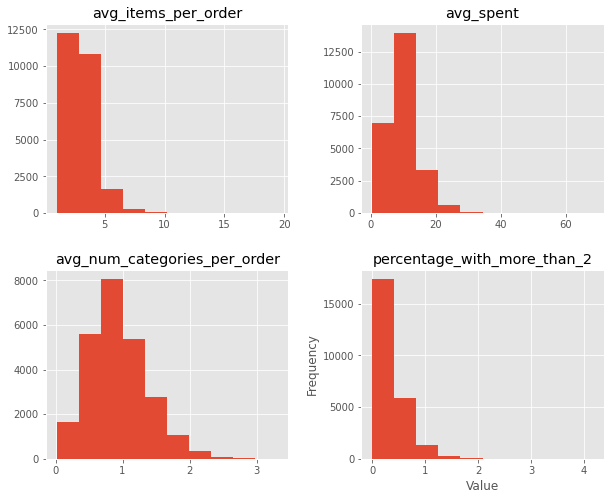

In [88]:
# Set style to 'ggplot'
plt.style.use('ggplot')

# Define a dictionary for custom colors
#colors = {'avg_items_per_order': '#FFC300', 'avg_spent': '#FF5733', 'avg_num_categories_per_order': '#C70039', 'percentage_with_more_than_2': '#be33ff'}
#colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F']

# Plot histograms of multiple columns with custom colors
#customers_df2[['avg_items_per_order', 'avg_spent', 'avg_num_categories_per_order','percentage_with_more_than_2']].hist(bins=10, color=colors, alpha=0.7, figsize=(18, 14))
#plt.hist([customers_df2['avg_items_per_order'], customers_df2['avg_spent'], customers_df2['avg_num_categories_per_order'], customers_df2['percentage_with_more_than_2']], color=colors)
customers_df2.hist(column=['avg_items_per_order', 'avg_spent', 'avg_num_categories_per_order', 'percentage_with_more_than_2'], figsize=(10, 8))

# Set axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
#plt.title('Histograms of avg_items_per_order, avg_spent,avg_num_categories_per_order and percentage_with_more_than_2')
# Show the legend with custom labels
#plt.legend(['avg_items_per_order', 'avg_spent', 'avg_num_categories_per_order', 'percentage_with_more_than_2'])

# Set the font size
plt.rcParams.update({'font.size': 14})

# Display the plot
plt.show()


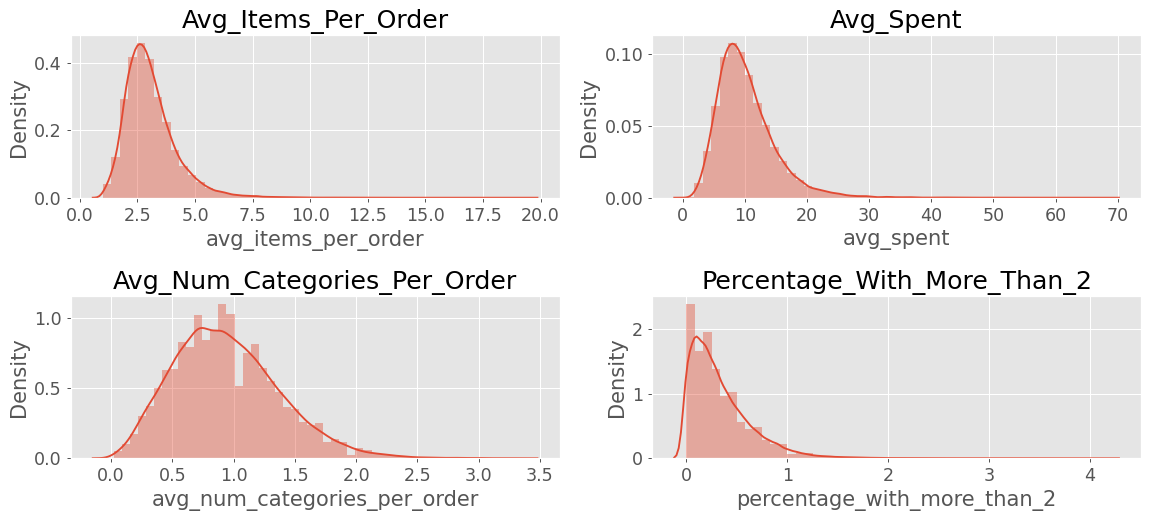

In [89]:
# Visualizing the distributions before and after log transformation.
target = ['avg_items_per_order', 'avg_spent',	'avg_num_categories_per_order', 'percentage_with_more_than_2']
plt.figure(figsize=(13,6), dpi=90)
for n,col in enumerate(target):
  plt.subplot(2, 2, n+1)
  sns.distplot(customers_df2[col])
  plt.title(col.title())
  plt.tight_layout()

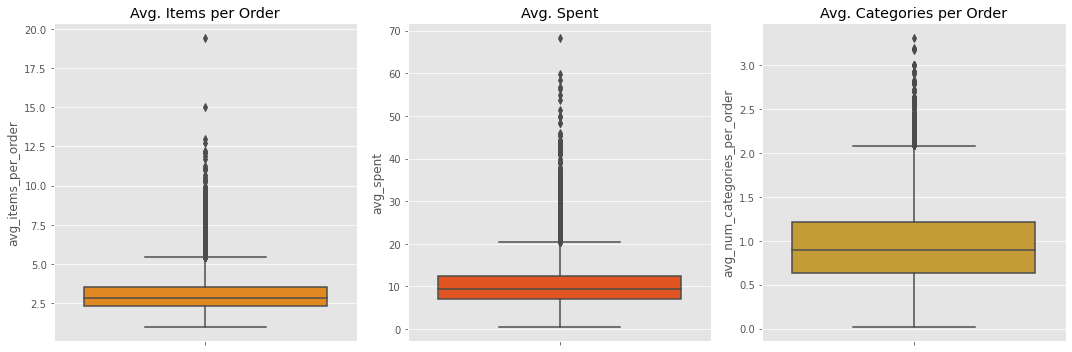

In [90]:
plt.style.use('ggplot')
# Create a boxplot for each variable
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.boxplot(y=customers_df2['avg_items_per_order'], ax=axes[0],color='darkorange')
sns.boxplot(y=customers_df2['avg_spent'], ax=axes[1],color='orangered')
sns.boxplot(y=customers_df2['avg_num_categories_per_order'], ax=axes[2],color='goldenrod')

# Set titles for each subplot
axes[0].set_title('Avg. Items per Order')
axes[1].set_title('Avg. Spent')
axes[2].set_title('Avg. Categories per Order')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Define quartiles and thresholds for the variables that will be used to decide the household size

In [91]:
# Calculate the quartiles of the variables
q1 = customers_df2[['avg_items_per_order', 'avg_spent', 'avg_num_categories_per_order']].quantile(0.25)
q2 = customers_df2[['avg_items_per_order', 'avg_spent', 'avg_num_categories_per_order']].quantile(0.5)
q3 = customers_df2[['avg_items_per_order', 'avg_spent', 'avg_num_categories_per_order']].quantile(0.75)

In [92]:
# Define the category thresholds
category_thresholds = {
    'avg_items_per_order': [
        (float('-inf'), q1['avg_items_per_order']),
        (q1['avg_items_per_order'], q2['avg_items_per_order']),
        (q2['avg_items_per_order'], q3['avg_items_per_order']),
        (q3['avg_items_per_order'], float('inf'))
    ],
    'avg_spent': [
        (float('-inf'), q1['avg_spent']),
        (q1['avg_spent'], q2['avg_spent']),
        (q2['avg_spent'], q3['avg_spent']),
        (q3['avg_spent'], float('inf'))
    ],
    'avg_num_categories_per_order': [
        (float('-inf'), q1['avg_num_categories_per_order']),
        (q1['avg_num_categories_per_order'], q2['avg_num_categories_per_order']),
        (q2['avg_num_categories_per_order'], q3['avg_num_categories_per_order']),
        (q3['avg_num_categories_per_order'], float('inf'))
    ]
}

In [93]:
category_thresholds

{'avg_items_per_order': [(-inf, 2.31),
  (2.31, 2.86),
  (2.86, 3.57),
  (3.57, inf)],
 'avg_spent': [(-inf, 7.02), (7.02, 9.35), (9.35, 12.3975), (12.3975, inf)],
 'avg_num_categories_per_order': [(-inf, 0.63),
  (0.63, 0.9),
  (0.9, 1.21),
  (1.21, inf)]}

In [94]:
# Define the categories based on the quartiles
def categorize(row):
    for col, thresholds in category_thresholds.items():
        if row[col] < thresholds[0][0]:
            return None
        for i, thresh in enumerate(thresholds):
            if row[col] < thresh[1]:
                return ['Single or Couple', 'Small Household', 'Small or Medium Household', 'Medium Household'][i]
    return None

customers_df2['household_size2'] = customers_df2.apply(categorize, axis=1)


In [95]:
customers_df2

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class,household_size2
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.45,4.41,0.71,0.29,0.00,0.0,0.00,0.32,True,0.00,0.06,0.94,False,0.0,Mystery Maven,0.26,0.74,Αθήνα,0.00,0.38,νοτιος τομεας αθηνων,18127,425112,Average income,Medium Household
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.58,2.48,1.05,0.48,0.15,0.0,0.62,0.00,False,0.25,0.45,0.30,False,0.0,Mystery Maven,0.22,0.78,Αθήνα,0.42,0.18,νοτιος τομεας αθηνων,18127,425112,Average income,Small Household
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.37,1.00,0.23,0.00,0.00,0.0,0.92,0.00,False,0.38,0.15,0.46,False,0.0,Mystery Maven,0.31,0.69,Κιλκίς,0.69,0.00,κιλκις,10609,85885,Low income,Single or Couple
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.50,1.10,0.08,0.00,0.00,0.0,0.00,0.00,False,0.84,0.16,0.00,False,0.0,Mystery Maven,0.18,0.82,Σπάρτη,0.02,0.00,λακωνια,11864,87104,Low income,Single or Couple
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.72,2.87,0.79,0.60,0.00,0.0,0.57,0.00,False,0.02,0.21,0.77,False,0.0,Mystery Maven,0.32,0.68,Αθήνα,0.19,0.23,νοτιος τομεας αθηνων,18127,425112,Average income,Small or Medium Household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.62,3.83,2.50,0.58,0.17,0.0,0.58,0.50,False,0.17,0.25,0.58,False,0.0,Mystery Maven,0.58,0.42,Αθήνα,0.25,0.17,δυτικος τομεας αθηνων,10608,405623,Low income,Medium Household
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.32,3.81,1.69,0.88,0.06,0.0,0.25,0.00,False,0.00,0.50,0.50,False,0.0,Mystery Maven,0.25,0.75,Αθήνα,0.31,0.12,βορειος τομεας αθηνων,25665,481758,High income,Medium Household
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.55,4.20,1.27,0.47,0.00,0.0,0.87,0.00,False,0.00,0.00,1.00,False,0.0,Mystery Maven,0.53,0.47,Αθήνα,0.13,0.40,δυτικος τομεας αθηνων,10608,405623,Low income,Medium Household
24996,fffacf61b056a50e5cf7173b94c939df,2,133.60,20,1183,8,48,21,6,"[Τυλιχτά προσφοράς Φάε με 5€, Κρουασάν σοκολάτ...","['Πάτρα', 'Αθήνα']","['Πάτρα', 'Αθήνα']","['Πάτρα 2', 'Αθήνα-Παγκράτι', 'Καισαριανή']","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Pizza',...",6

In [96]:
# Define a function to categorize customers based on their order frequency and other variables
# def categorize_customers(df):
#     # Calculate the total number of items purchased
#     customers_df2['total_items'] = customers_df2['number_of_orders'] * customers_df2['number_of_items_per_order']
    
#     # Calculate the average number of items per order
#     customers_df2['avg_items_per_order'] = customers_df2['total_items'] / customers_df2['number_of_orders']
     
#     # Create a dictionary to map order frequency to household size
#     frequency_map = {
#         '1-2 times': 1,
#         '3-4 times': 2,
#         '5-6 times': 3,
#         '7+ times': 4
#     }
    
#     # Map order frequency to household size
#     customers_df2['household_size'] = customers_df2['frequency_of_orders'].map(frequency_map)
  
  # Create a function to categorize customers based on their household size and other variables
def categorize(row):
    if row['avg_items_per_order'] <= 2.86:
        if row['avg_spent'] <= 7:
            if row['avg_num_categories_per_order'] <= 0.6:
                return 'Single or Couple'
            else:
                return 'Small Household'
        else:
            if row['avg_num_categories_per_order'] <= 0.6:
                return 'Single or Couple'
            else:
                return 'Small or Medium Household'
    else:
        if row['avg_spent'] <= 9:
            if row['avg_num_categories_per_order'] <= 0.6:
                return 'Small or Medium Household'
            else:
                return 'Medium Household'
        else:
            if row['avg_num_categories_per_order'] <= 0.6:
                return 'Small or Medium Household'
            else:
                return 'Large Household'

    return customers_df2


# Apply the categorize function to each row of the DataFrame
customers_df2['household_size'] = customers_df2.apply(categorize, axis=1)

In [97]:
customers_df2[customers_df2['customer_id']=='0001496e540173a40362759ed10b3ce2']

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class,household_size2,household_size
0,0001496e540173a40362759ed10b3ce2,2,423.4,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.45,4.41,0.71,0.29,0.0,0.0,0.0,0.32,True,0.0,0.06,0.94,False,0.0,Mystery Maven,0.26,0.74,Αθήνα,0.0,0.38,νοτιος τομεας αθηνων,18127,425112,Average income,Medium Household,Large Household


In [98]:
df[df.customer_id=='9f18fde21cc7e22a2400b2b43761fe34'] #company

,customer_id,order_id,order_timestamp,item_name,category_name,item_price,item_quantity,shop_id,shop_is_chain,delivered_by_efood,shop_cuisine,is_online_payment,order_has_discount_coupon,order_from_pinata,geographical_region_of_user,shop_city,geographical_region_of_shop,food_score,delivery_score,service_score,last_order_at,first_order_at,year,month,dayname,hour,day,TotalSum,part_of_the_day,timestamp,week,weekday,weekofyear,left_review
137735,9f18fde21cc7e22a2400b2b43761fe34,84fd7a5e412b2412a9acd4ff153aa8d0,2021-05-12 15:07:42+00:00,φιλετίνια κοτόπουλου goody`s,Goody`s Signatures Wraps & Sandwiches,5.5,1,e641ac1140fda157d70b14889217ef31,1,0,Burgers,0,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Wednesday,15,2,5.5,Afternoon,2021-05-12,19,2,19,0
137736,9f18fde21cc7e22a2400b2b43761fe34,84fd7a5e412b2412a9acd4ff153aa8d0,2021-05-12 15:07:42+00:00,b&j strawberry cheesecake 100ml,Παγωτά,2.7,1,e641ac1140fda157d70b14889217ef31,1,0,Burgers,0,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Wednesday,15,2,2.7,Afternoon,2021-05-12,19,2,19,0
228488,9f18fde21cc7e22a2400b2b43761fe34,d5a401abdb2ca9c15377f293f020de85,2021-04-23 08:09:02+00:00,κουλούρι κλασικό αφράτο,Νηστίσιμα,0.5,2,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,April,Friday,8,4,1.0,Morning,2021-04-23,16,4,16,0
228489,9f18fde21cc7e22a2400b2b43761fe34,d5a401abdb2ca9c15377f293f020de85,2021-04-23 08:09:02+00:00,κουλούρι κλασικό τραγανό,Νηστίσιμα,0.5,15,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,April,Friday,8,4,7.5,Morning,2021-04-23,16,4,16,0
228490,9f18fde21cc7e22a2400b2b43761fe34,d5a401abdb2ca9c15377f293f020de85,2021-04-23 08:09:02+00:00,μπουκίτσες με τυρί κρέμα,Κουλούρια μπουκίτσες γεμιστά,0.6,6,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,April,Friday,8,4,3.6,Morning,2021-04-23,16,4,16,0
255343,9f18fde21cc7e22a2400b2b43761fe34,8529ac31f213598dc28467d191857c85,2021-05-07 08:07:13+00:00,κουλούρι κλασικό τραγανό,Νηστίσιμα,0.5,10,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Friday,8,4,5.0,Morning,2021-05-07,18,4,18,0
255344,9f18fde21cc7e22a2400b2b43761fe34,8529ac31f213598dc28467d191857c85,2021-05-07 08:07:13+00:00,μπουκίτσες με τυρί κρέμα,Κουλούρια μπουκίτσες γεμιστά,0.6,6,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Friday,8,4,3.6,Morning,2021-05-07,18,4,18,0
255345,9f18fde21cc7e22a2400b2b43761fe34,8529ac31f213598dc28467d191857c85,2021-05-07 08:07:13+00:00,κουλούρι με τυρί arla,Κουλούρια αλμυρά,1.0,3,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Friday,8,4,3.0,Morning,2021-05-07,18,4,18,0
285646,9f18fde21cc7e22a2400b2b43761fe34,e04bac2b47b878067b256f7a30ae5b30,2021-05-17 08:40:22+00:00,κουλούρι με τυρί arla,Κουλούρια αλμυρά,1.0,2,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Monday,8,0,2.0,Morning,2021-05-17,20,0,20,0
285647,9f18fde21cc7e22a2400b2b43761fe34,e04bac2b47b878067b256f7a30ae5b30,2021-05-17 08:40:22+00:00,μπουκίτσες με τυρί κρέμα,Κουλούρια μπουκίτσες γεμιστά,0.6,6,9328089b1989cda3a41065464a53bd60,1,1,Κουλούρια,1,0,0,Αθήνα,Αθήνα,Αγία Παρασκευή,NaN,NaN,NaN,2021-05-26,2021-03-17,2021,May,Monday,8,0,3.6,Morning,2021-05-17,20,0,20,0


In [99]:
customers_df2['household_size'].value_counts()

Large Household              9190
Small or Medium Household    7355
Single or Couple             4302
Small Household              2317
Medium Household             1834
Name: household_size, dtype: int64

In [100]:
customers_df2['household_size2'].value_counts()

Small or Medium Household    6349
Medium Household             6267
Small Household              6238
Single or Couple             6144
Name: household_size2, dtype: int64

In [101]:
# customers_df2['marital_status'].value_counts()

In [102]:
# customers_df2[customers_df2['marital_status']=='Family']

In [103]:
customers_df2[customers_df2['household_size']=='Large Household']

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class,household_size2,household_size
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.45,4.41,0.71,0.29,0.00,0.0,0.00,0.32,True,0.00,0.06,0.94,False,0.0,Mystery Maven,0.26,0.74,Αθήνα,0.00,0.38,νοτιος τομεας αθηνων,18127,425112,Average income,Medium Household,Large Household
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.72,2.87,0.79,0.60,0.00,0.0,0.57,0.00,False,0.02,0.21,0.77,False,0.0,Mystery Maven,0.32,0.68,Αθήνα,0.19,0.23,νοτιος τομεας αθηνων,18127,425112,Average income,Small or Medium Household,Large Household
8,0024b8e15cb74e9662a90acf254fa7d6,3,186.60,16,684,3,61,17,3,"[Eggs & pancake, Smoothies, Συσκευασμένοι χυμο...",['Θεσσαλονίκη'],['Θεσσαλονίκη'],['Θεσσαλονίκη-Πυλαία-Πανόραμα'],"['Sandwich', 'Καφέδες', 'Pizza']",11.66,3.81,0.75,1.00,0.00,0.0,0.00,0.00,False,0.44,0.31,0.25,False,0.0,Mystery Maven,0.25,0.75,Θεσσαλονίκη,0.06,1.00,θεσσαλονικη,13091,884945,Average income,Medium Household,Large Household
11,0034658999072772a49e8ca63055f83e,3,570.60,58,1972,28,178,84,9,"[Αραβικές πίτες, My crepa, Club sandwich 5€, Κ...",['Αθήνα'],['Αθήνα'],"['Καλλιθέα-Ανατολικά', 'Βάρη-Βουλιαγμένη']","['Λουκουμάδες', 'Σουβλάκια', 'Μαγειρευτά', 'Κρ...",9.84,3.07,0.78,0.67,0.00,0.0,0.40,0.19,True,0.40,0.45,0.16,False,0.0,Mystery Maven,0.19,0.81,Αθήνα,0.52,0.12,ανατολικη αττικη,15987,403714,Average income,Small or Medium Household,Large Household
12,0036fe81d8e79e4feb8befb2f43783f1,19,182.40,11,1636,7,51,22,5,"[Νηστίσιμο menu, Καφέδες, Τεμάχια, Της πατάτας...",['Αθήνα'],['Αθήνα'],"['Χολαργός-Παπάγου', 'Αγία Παρασκευή']","['Σουβλάκια', 'Pizza', 'Καφέδες', 'Ζαχαροπλαστ...",16.58,4.64,1.73,0.91,0.00,0.0,0.00,0.09,False,0.00,0.73,0.27,False,0.0,Mystery Maven,0.55,0.45,Αθήνα,0.27,0.82,βορειος τομεας αθηνων,25665,481758,High income,Medium Household,Large Household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24991,ffe5d1943222e427eb7a634086a8d478,7,389.25,19,155,17,106,60,10,"[Sushi inside οut, Νερά, Κοτόπουλο, Σάντουιτς,...",['Θεσσαλονίκη'],['Θεσσαλονίκη'],"['Θεσσαλονίκη-Πυλαία-Πανόραμα', 'Θεσσαλονίκη-Χ...","['Σουβλάκια', 'Μαγειρευτά', 'Κρέπες', 'Cocktai...",20.49,5.58,2.05,0.63,0.26,0.0,1.00,0.00,False,0.00,0.53,0.47,False,0.0,Mystery Maven,0.32,0.68,Θεσσαλονίκη,0.21,0.89,θεσσαλονικη,13091,884945,Average income,Medium Household,Large Household
24992,ffe7a339b76f0bf9f5ed4d3476ee8829,5,237.10,18,1426,15,66,35,6,"[My crepa, Σάντουιτς, Καφέδες, Σάντουιτς καλαμ...","['Πειραιάς', 'Αθήνα']",['Πειραιάς'],['Νίκαια'],"['Σουβλάκια', 'Κρέπες', 'Καφέδες', 'Kebab', 'B...",13.17,3.67,1.61,0.33,0.00,0.0,0.33,0.00,False,0.00,0.22,0.78,False,0.0,Mystery Maven,0.11,0.89,Πειραιάς,0.06,0.61,πειραιας,18143,388480,Average income,Medium Household,Large Household
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.62,3.83,2.50,0.58,0.17,0.0,0.58,0.50,False,0.17,0.25,0.58,False,0.0,Mystery Maven,0.58,0.42,Αθή

## Cuisines exploration

### Split customers based on how adventurous they are with their choices of food 

In [104]:
test = pd.DataFrame(customers_df2.cuisines.values.tolist()).stack().value_counts()

In [105]:
top_5_lists = test.head(20)
top_5_lists

['Καφέδες', 'Σουβλάκια']                                      550
['Pizza', 'Καφέδες', 'Σουβλάκια']                             442
['Σουβλάκια', 'Κρέπες', 'Pizza', 'Καφέδες', 'Burgers']        422
['Pizza', 'Σουβλάκια', 'Καφέδες']                             363
['Pizza', 'Καφέδες', 'Σουβλάκια', 'Burgers']                  323
['Καφέδες']                                                   289
['Σουβλάκια', 'Καφέδες']                                      266
['Pizza', 'Σουβλάκια', 'Καφέδες', 'Burgers']                  257
['Καφέδες', 'Σουβλάκια', 'Burgers']                           226
['Pizza', 'Σουβλάκια', 'Κρέπες', 'Καφέδες']                   210
['Pizza', 'Καφέδες', 'Κρέπες', 'Σουβλάκια']                   210
['Pizza', 'Σουβλάκια']                                        208
['Pizza', 'Σουβλάκια', 'Burgers']                             183
['Σουβλάκια', 'Κρέπες', 'Καφέδες']                            150
['Pizza', 'Καφέδες']                                          129
['Σουβλάκι

In [106]:
unique_cuisines = customers_df2['cuisines'].str.split(', ', expand=True).stack().value_counts().head(20).index
unique_cuisines

Index([''Καφέδες'', '['Σουβλάκια'', ''Pizza'', ''Κρέπες'', ''Burgers']',
       ''Σουβλάκια'', ''Burgers'', ''Μαγειρευτά'', '['Pizza'', ''Sushi'',
       ''Καφέδες']', ''Ψητά - Grill']', '['Καφέδες'', ''Κινέζικη'',
       ''Σουβλάκια']', ''Ζαχαροπλαστείο'', ''Ζυμαρικά'', ''Brunch']',
       ''Κοτόπουλα']', ''Ψητά - Grill''],
      dtype='object')

In [107]:
top_20_cuisines = df.shop_cuisine.value_counts().head(20).index.tolist()
top_20_cuisines

['Καφέδες',
 'Σουβλάκια',
 'Burgers',
 'Pizza',
 'Κρέπες',
 'Μαγειρευτά',
 'Ψητά - Grill',
 'Sushi',
 'Brunch',
 'Αρτοποιήματα',
 'Κουλούρια',
 'Κινέζικη',
 'Μπουγάτσα',
 'Κοτόπουλα',
 'Sandwich',
 'Ζαχαροπλαστείο',
 'Kebab',
 'Ζυμαρικά',
 'Ασιατική',
 'Θαλασσινά']

In [108]:
bottom_5_lists = test.tail(20)
bottom_5_lists

['Αρτοποιήματα', 'Σουβλάκια', 'Μαγειρευτά', 'Ζυμαρικά', 'Pizza', 'Καφέδες', 'Burgers', 'Brunch']                                                                              1
['Pizza', 'Μπουγάτσα', 'Καφέδες', 'Ζαχαροπλαστείο', 'Burgers', 'Κοτόπουλα']                                                                                                   1
['Αρτοποιήματα', 'Σουβλάκια', 'Κρέπες', 'Ζυμαρικά', 'Cocktails', 'Pizza', 'Παγωτό', 'Κινέζικη', 'Καφέδες']                                                                    1
['Σουβλάκια', 'Cocktails', 'Ασιατική', 'Καφέδες', 'Θαλασσινά', 'Burgers']                                                                                                     1
['Σουβλάκια', 'Κρέπες', 'Pizza', 'Κινέζικη', 'Καφέδες', 'Sushi', 'Kebab', 'Γλυκά', 'Burgers', 'Κοτόπουλα']                                                                    1
['Λουκουμάδες', 'Σουβλάκια', 'Κρέπες', 'Pizza', 'Παγωτό', 'Μπουγάτσα', 'Καφέδες', 'Sushi', 'Σαλάτες', 'Burgers', 'Ψητά -

In [109]:
for list_name, count in top_5_lists.items():
    print(f"{list_name}: {count}")

['Καφέδες', 'Σουβλάκια']: 550
['Pizza', 'Καφέδες', 'Σουβλάκια']: 442
['Σουβλάκια', 'Κρέπες', 'Pizza', 'Καφέδες', 'Burgers']: 422
['Pizza', 'Σουβλάκια', 'Καφέδες']: 363
['Pizza', 'Καφέδες', 'Σουβλάκια', 'Burgers']: 323
['Καφέδες']: 289
['Σουβλάκια', 'Καφέδες']: 266
['Pizza', 'Σουβλάκια', 'Καφέδες', 'Burgers']: 257
['Καφέδες', 'Σουβλάκια', 'Burgers']: 226
['Pizza', 'Σουβλάκια', 'Κρέπες', 'Καφέδες']: 210
['Pizza', 'Καφέδες', 'Κρέπες', 'Σουβλάκια']: 210
['Pizza', 'Σουβλάκια']: 208
['Pizza', 'Σουβλάκια', 'Burgers']: 183
['Σουβλάκια', 'Κρέπες', 'Καφέδες']: 150
['Pizza', 'Καφέδες']: 129
['Σουβλάκια', 'Μαγειρευτά', 'Pizza', 'Καφέδες', 'Burgers']: 128
['Σουβλάκια', 'Καφέδες', 'Burgers']: 128
['Pizza', 'Σουβλάκια', 'Κρέπες']: 114
['Σουβλάκια']: 113
['Pizza', 'Σουβλάκια', 'Κρέπες', 'Burgers']: 108


In [110]:
# Calculate the total number of users in the dataset
total_users = len(customers_df2)

# Calculate the percentage of each list
list_percentages = (test.head(20) / total_users) * 100

# Print the top 5 lists and their corresponding percentages
for list_name, percentage in list_percentages.head(20).items():
    print(f"{list_name}: {percentage:.2f}%")


['Καφέδες', 'Σουβλάκια']: 2.20%
['Pizza', 'Καφέδες', 'Σουβλάκια']: 1.77%
['Σουβλάκια', 'Κρέπες', 'Pizza', 'Καφέδες', 'Burgers']: 1.69%
['Pizza', 'Σουβλάκια', 'Καφέδες']: 1.45%
['Pizza', 'Καφέδες', 'Σουβλάκια', 'Burgers']: 1.29%
['Καφέδες']: 1.16%
['Σουβλάκια', 'Καφέδες']: 1.06%
['Pizza', 'Σουβλάκια', 'Καφέδες', 'Burgers']: 1.03%
['Καφέδες', 'Σουβλάκια', 'Burgers']: 0.90%
['Pizza', 'Σουβλάκια', 'Κρέπες', 'Καφέδες']: 0.84%
['Pizza', 'Καφέδες', 'Κρέπες', 'Σουβλάκια']: 0.84%
['Pizza', 'Σουβλάκια']: 0.83%
['Pizza', 'Σουβλάκια', 'Burgers']: 0.73%
['Σουβλάκια', 'Κρέπες', 'Καφέδες']: 0.60%
['Pizza', 'Καφέδες']: 0.52%
['Σουβλάκια', 'Μαγειρευτά', 'Pizza', 'Καφέδες', 'Burgers']: 0.51%
['Σουβλάκια', 'Καφέδες', 'Burgers']: 0.51%
['Pizza', 'Σουβλάκια', 'Κρέπες']: 0.46%
['Σουβλάκια']: 0.45%
['Pizza', 'Σουβλάκια', 'Κρέπες', 'Burgers']: 0.43%


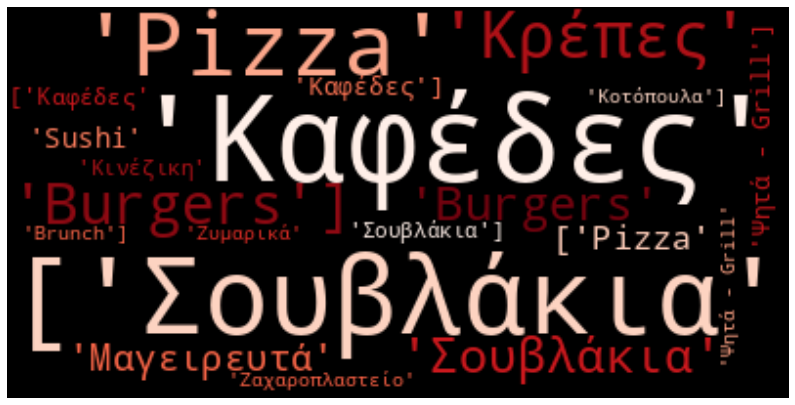

In [111]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a dictionary with the top 20 cuisine values as keys and their counts as values
cuisine_counts = dict(customers_df2['cuisines'].str.split(', ', expand=True).stack().value_counts().head(20))

# Define the WordCloud object with the desired parameters
wc = WordCloud(background_color='black', colormap='Reds', max_words=20)

# Generate the wordcloud using the cuisine_counts dictionary
wc.generate_from_frequencies(cuisine_counts)

# Display the wordcloud using matplotlib
plt.figure(figsize=(14,14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [112]:
customers_df2['cuisine_diversity'] = customers_df2['num_cuisines'] / customers_df2['num_orders']


In [113]:
# Calculate the average number of shops, categories, and cuisines for each customer
customers_df2['avg_shops'] = customers_df2['num_shops'] / customers_df2['num_orders'] 

In [114]:
customers_df2.num_cuisines.describe()

count    24998.000000
mean         5.252460
std          2.315425
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         21.000000
Name: num_cuisines, dtype: float64

In [115]:
customers_df2.avg_shops.describe()

count    24998.000000
mean         0.488587
std          0.206010
min          0.015385
25%          0.333333
50%          0.476190
75%          0.636364
max          1.000000
Name: avg_shops, dtype: float64

In [116]:
customers_df2.cuisine_diversity.describe()

count    24998.000000
mean         0.274096
std          0.136662
min          0.009009
25%          0.171429
50%          0.250000
75%          0.363005
max          1.000000
Name: cuisine_diversity, dtype: float64

In [117]:
# Define the labels based on the average values
def label_customer_on_cuisines(row):
    if row['avg_shops'] > 0.6 and row['cuisine_diversity'] > 0.33 and row['num_cuisines']>8:
        return 'Foodie'
    elif row['avg_shops'] > 0.4 and row['cuisine_diversity'] > 0.25  and row['num_cuisines']>5:
        return 'Adventurous'
    elif row['avg_shops'] > 0.1  and row['num_cuisines']>3:
        return 'Unadventurous'
    else:
        return 'Plain Jane/John'

# Apply the labels to each row in the DataFrame
customers_df2['foodie_label'] = customers_df2.apply(label_customer_on_cuisines, axis=1)


In [118]:
customers_df2['foodie_label'].value_counts()

Unadventurous      12978
Plain Jane/John     5751
Adventurous         5532
Foodie               737
Name: foodie_label, dtype: int64

In [119]:
customers_df2

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class,household_size2,household_size,cuisine_diversity,avg_shops,foodie_label
0,0001496e540173a40362759ed10b3ce2,2,423.40,34,479,17,150,52,2,"[Θρακόψωμο 5€ Deals, Αραβικές πίτες, Σάντουιτς...",['Αθήνα'],['Αθήνα'],['Νέα Σμύρνη'],"['Σουβλάκια', 'Μαγειρευτά']",12.45,4.41,0.71,0.29,0.00,0.0,0.00,0.32,True,0.00,0.06,0.94,False,0.0,Mystery Maven,0.26,0.74,Αθήνα,0.00,0.38,νοτιος τομεας αθηνων,18127,425112,Average income,Medium Household,Large Household,0.058824,0.500000,Plain Jane/John
1,0003b7de618c1acfc67eac91b853b287,4,343.35,40,1273,23,99,61,9,"[Κοτόπουλο, Our Burger Meals | Single Burger, ...",['Αθήνα'],['Αθήνα'],"['Αθήνα-Ιλίσια-Μαβίλη', 'Παλαιό Φάληρο', 'Αθήν...","['Σουβλάκια', 'Κουλούρια', 'Ζυμαρικά', 'Κρέπες...",8.58,2.48,1.05,0.48,0.15,0.0,0.62,0.00,False,0.25,0.45,0.30,False,0.0,Mystery Maven,0.22,0.78,Αθήνα,0.42,0.18,νοτιος τομεας αθηνων,18127,425112,Average income,Small Household,Small or Medium Household,0.225000,0.575000,Unadventurous
2,00045e9d1c96d7e2353f886704e51c88,13,43.80,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.37,1.00,0.23,0.00,0.00,0.0,0.92,0.00,False,0.38,0.15,0.46,False,0.0,Mystery Maven,0.31,0.69,Κιλκίς,0.69,0.00,κιλκις,10609,85885,Low income,Single or Couple,Single or Couple,0.230769,0.307692,Plain Jane/John
3,000e223791e890e85938d71bee32cf5a,3,122.50,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.50,1.10,0.08,0.00,0.00,0.0,0.00,0.00,False,0.84,0.16,0.00,False,0.0,Mystery Maven,0.18,0.82,Σπάρτη,0.02,0.00,λακωνια,11864,87104,Low income,Single or Couple,Single or Couple,0.040816,0.040816,Plain Jane/John
4,0016652ea3c3a1176dd2385e89de9ff6,2,456.70,47,1972,23,135,58,7,"[Hot dog, Sauces, Αναψυκτικά 330ml 5€ deals, M...",['Αθήνα'],['Αθήνα'],"['Ηλιούπολη', 'Αθήνα-Παγκράτι']","['Σουβλάκια', 'Κρέπες', 'Cocktails', 'Pizza', ...",9.72,2.87,0.79,0.60,0.00,0.0,0.57,0.00,False,0.02,0.21,0.77,False,0.0,Mystery Maven,0.32,0.68,Αθήνα,0.19,0.23,νοτιος τομεας αθηνων,18127,425112,Average income,Small or Medium Household,Large Household,0.148936,0.489362,Unadventurous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24993,ffea41c4dcc53a7ffd316f22ddb97be7,3,223.45,12,1901,11,46,39,7,"[Κοτόπουλο, My crepa, Καφέδες, My waffle, Burg...",['Αθήνα'],['Αθήνα'],"['Περιστέρι-Δυτικά', 'Νέα Ερυθραία-Εκάλη-Δροσι...","['Σουβλάκια', 'Βάφλες', 'Κρέπες', 'Ιταλική', '...",18.62,3.83,2.50,0.58,0.17,0.0,0.58,0.50,False,0.17,0.25,0.58,False,0.0,Mystery Maven,0.58,0.42,Αθήνα,0.25,0.17,δυτικος τομεας αθηνων,10608,405623,Low income,Medium Household,Large Household,0.583333,0.916667,Adventurous
24994,fff262fbc647360700cee69566e26989,3,165.15,16,1126,10,61,39,4,"[Καλαμάκια, Κοτόπουλο, Our Burger Meals | Sing...",['Αθήνα'],['Αθήνα'],['Βριλήσσια'],"['Καφέδες', 'Κρέπες', 'Σουβλάκια', 'Burgers']",10.32,3.81,1.69,0.88,0.06,0.0,0.25,0.00,False,0.00,0.50,0.50,False,0.0,Mystery Maven,0.25,0.75,Αθήνα,0.31,0.12,βορειος τομεας αθηνων,25665,481758,High income,Medium Household,Large Household,0.250000,0.625000,Unadventurous
24995,fff355794e97eaaf07f53f4fdb4d0cd2,3,248.20,15,1265,7,63,35,5,"[Σάντουιτς, Καφέδες, Τεμάχια, Μπύρες | Ποτά, Μ...",['Αθήνα'],['Αθήνα'],['Πετρούπολη-Καματερό'],"['Σουβλάκια', 'Ασιατική', 'Καφέδες', 'Burgers'...",16.55,4.2

## Create bins according to how populous an area in Greece is

In [120]:
# Define bins for population segmentation
bins = [0, 90000, 250000, 450000, 500000, float('inf')]

# Create a new column for population segment
customers_df2['population_segment'] = pd.cut(customers_df2['population'], bins, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], right=False)


In [121]:
customers_df2['population_segment'].value_counts()

Medium       10336
Very High     7071
Low           4062
High          3097
Very Low       432
Name: population_segment, dtype: int64

In [122]:
customers_df2[customers_df2['population_segment']=='Very Low']

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class,household_size2,household_size,cuisine_diversity,avg_shops,foodie_label,population_segment
2,00045e9d1c96d7e2353f886704e51c88,13,43.8,13,263,4,13,5,3,"[Καφέδες, Club sandwiches, Burgers]",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Pizza', 'Καφέδες', 'Κρέπες']",3.37,1.00,0.23,0.00,0.0,0.0,0.92,0.00,False,0.38,0.15,0.46,False,0.0,Mystery Maven,0.31,0.69,Κιλκίς,0.69,0.00,κιλκις,10609,85885,Low income,Single or Couple,Single or Couple,0.230769,0.307692,Plain Jane/John,Very Low
3,000e223791e890e85938d71bee32cf5a,3,122.5,49,501,2,54,5,2,"[Καφέδες, Sandwiches, Σαλάτες, Burgers]",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες']",2.50,1.10,0.08,0.00,0.0,0.0,0.00,0.00,False,0.84,0.16,0.00,False,0.0,Mystery Maven,0.18,0.82,Σπάρτη,0.02,0.00,λακωνια,11864,87104,Low income,Single or Couple,Single or Couple,0.040816,0.040816,Plain Jane/John,Very Low
70,00c4e6212562cccb2cf3d8cb88aadeff,3,157.2,19,234,10,74,26,5,"[Cheeseburger με πατάτες 5€ deals, Κουλούρια Θ...","['Άγιος Νικόλαος Κρήτη', 'Σέρρες']","['Άγιος Νικόλαος Κρήτη', 'Σέρρες']","['Άγιος Νικόλαος Κρήτης', 'Σέρρες']","['Σουβλάκια', 'Pizza', 'Καφέδες', 'Burgers', '...",8.27,3.89,1.05,0.21,0.0,0.0,0.42,0.00,False,0.16,0.53,0.32,False,0.0,Mystery Maven,0.32,0.68,Άγιος Νικόλαος Κρήτη,0.26,0.53,κρητη,12374,73258,Low income,Medium Household,Medium Household,0.263158,0.526316,Unadventurous,Very Low
98,01134609de2913d59778d41ec6b60533,4,155.5,18,567,9,49,15,4,"[Pancakes γλυκά, Τηγανόψωμο, Κριτσίνια το κιλό...","['Σπάρτη', 'Αθήνα']","['Σπάρτη', 'Αθήνα']","['Σπάρτη', 'Χαλάνδρι-Κάτω']","['Pizza', 'Σουβλάκια', 'Μαγειρευτά', 'Καφέδες']",8.64,2.72,0.67,0.17,0.0,0.0,0.00,0.06,False,0.17,0.56,0.28,False,0.0,Mystery Maven,0.06,0.94,Σπάρτη,0.39,0.22,λακωνια,11864,87104,Low income,Small Household,Small or Medium Household,0.222222,0.500000,Unadventurous,Very Low
137,016794f5d4800c7403bd1ed8d0f3b10b,21,371.2,23,904,3,105,19,3,"[Λουκουμάδες, Ζυμαρικά, Pizza, Αναψυκτικά, Καφ...",['Σπάρτη'],['Σπάρτη'],"['Σπάρτη', 'Γύθειο']","['Pizza', 'Σουβλάκια', 'Καφέδες']",16.14,4.57,0.52,0.00,0.0,0.0,0.52,0.00,False,0.04,0.04,0.91,False,0.0,Mystery Maven,0.09,0.91,Σπάρτη,0.04,0.87,λακωνια,11864,87104,Low income,Medium Household,Small or Medium Household,0.130435,0.130435,Plain Jane/John,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24802,fe0d690eea11ed7f874e1f99fe03a245,5,99.2,14,51,2,30,12,2,"[Snacks, Αναψυκτικά, Καφέδες, Σαλάτες, Burgers...",['Κιλκίς'],['Κιλκίς'],['Κιλκίς'],"['Σουβλάκια', 'Καφέδες']",7.09,2.14,0.43,0.00,0.0,0.0,1.00,0.00,False,0.00,0.64,0.36,False,0.0,Mystery Maven,0.21,0.79,Κιλκίς,0.29,0.29,κιλκις,10609,85885,Low income,Single or Couple,Single or Couple,0.142857,0.142857,Plain Jane/John,Very Low
24805,fe1a2a4032c3d087509dfd4493448b0e,12,232.3,23,1203,10,78,26,4,"[Τυρόπιτα προσφοράς, My crepa, Καφέδες, Τεμάχι...",['Σπάρτη'],['Σπάρτη'],['Σπάρτη'],"['Pizza', 'Καφέδες', 'Σουβλάκια', 'Donuts']",10.10,3.39,1.09,0.35,0.0,0.0,0.13,0.00,False,0.04,0.48,0.48,False,0.0,Mystery Maven,0.26,0.74,Σπάρτη,0.35,0.22,λακωνια,11864,87104,Low income,Small or Medium Household,Large Household,0.173913,0.434783,Unadventurous,Very Low
24908,ff1a2e222c67aaa97bfa8f76aff27342,2,69.6,10,1297,9,21,17,4,"[Σκεπαστές προσφοράς, Γλυκά κρουασάν, Espresso...","['Αθήνα', 'Κως']","['Αθήνα', 'Κως']","['Κώς', 'Άλιμος']","['Καφέδες', 'Σουβλάκια', 

In [123]:
# find rows with null values
null_mask = customers_df2.isnull().any(axis=1)
null_rows = customers_df2[null_mask]


In [124]:
null_rows

,customer_id,recency,monetary,num_orders,days_active,num_shops,num_items,var_order_items,num_cuisines,categories,city,region,shop_regions,cuisines,avg_spent,avg_items_per_order,avg_num_categories_per_order,perc_chain_shops,perc_delivered_by_efood,perc_has_discount_coupon,perc_paid_online,perc_from_pinata,orders_every_week,morning_perc,afternoon_perc,night_perc,ordered_3_days_every_week,scores_count,leaves_reviews,weekend_orders_pct,weekday_orders_pct,geographical_region_of_user,coffee_percentage,percentage_with_more_than_2,prefecture,GDP,population,income_class,household_size2,household_size,cuisine_diversity,avg_shops,foodie_label,population_segment


In [125]:
# Calculate average purchase value by population segment
customers_df2.groupby('population_segment')['monetary'].mean()

population_segment
Very Low     172.207454
Low          187.475162
Medium       225.234333
High         257.702218
Very High    222.286686
Name: monetary, dtype: float64

In [126]:
# Calculate purchase frequency by population segment
customers_df2.groupby('population_segment')['num_orders'].mean()

population_segment
Very Low     21.923611
Low          22.512802
Medium       23.415248
High         22.880207
Very High    22.799463
Name: num_orders, dtype: float64

In [127]:
customers_df2.to_csv("customers_new.csv",index=False)